<a href="https://colab.research.google.com/github/heroza/Image-Augmentation/blob/main/no%20preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [51]:
#exp_name="smote on IS far from centroid"
exp_name="no preprocessing"
dataset_name="under70_128px_raw"
train_under_frac = 0.7

# input image size
IMAGE_W = 128
IMAGE_H = 128
IMG_SIZE = (IMAGE_W,IMAGE_H)
num_classes = 7
EPOCHS = 50
BATCH_SIZE = 64
the_arch = 'resnet50'

#Library, atribut, and function

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import imblearn
import cv2
from collections import Counter
from pathlib import Path
from PIL import Image
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score, confusion_matrix, accuracy_score, fbeta_score
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Dropout, Flatten
from tensorflow.keras.models import Model, load_model
from keras.utils.np_utils import to_categorical
from imblearn.over_sampling import SMOTE, SVMSMOTE, ADASYN, KMeansSMOTE, BorderlineSMOTE
from skimage import io

In [4]:
# load train and test dataset
def preprocess_image_input(input_images, arch = the_arch):
  print("preprocess data")
  input_images = input_images.astype('float32')
  if arch == 'inception_v3':
    output_ims = tf.keras.applications.inception_v3.preprocess_input(input_images)
  else:
    output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims

def load_cifar10_dataset():
  from keras.datasets import cifar10
    # load dataset
  (X_train, y_train), (X_val, y_val) = cifar10.load_data()
    # one hot encode target values
  y_train = to_categorical(y_train)
  y_val = to_categorical(y_val)

  return X_train, y_train, X_val, y_val

def load_mnist_dataset():
  (X_train, y_train), (X_val, y_val) = keras.datasets.mnist.load_data()
  X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
  X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
  y_train = to_categorical(y_train)
  y_val = to_categorical(y_val)

  return X_train, y_train, X_val, y_val

def true_positive(l1,l2):
  tp = 0
  for i in range(len(l1)):
    tp = tf.cond(l1[i]==l2[i]==1, lambda: tp+1)
  return tp

def true_negative(l1,l2):
  tn = 0
  for i in range(len(l1)):
    tn = tf.cond(l1[i]==l2[i]==0, lambda: tn+1)
  return tn

def false_positive(l1,l2):
  fp = 0
  for i in range(len(l1)):
    fp = tf.cond(l1[i] != l2[i] and l2[i]==1, lambda: fp+1)
  return fp

def false_negative(l1,l2):
  fn = 0
  for i in range(len(l1)):
    fn = tf.cond(l1[i] != l2[i] and l2[i] == 0, lambda: fn+1)
  return fn

def balanced_acc2(y_true,y_pred):
  
  a = y_true.numpy()
  b = y_pred.numpy()
  return balanced_accuracy_score(a,b)

def balanced_acc(y_true,y_pred):
    from keras import backend as K
    tensor1 = tf.math.argmax(y_true, axis=1)
    tensor2 = tf.math.argmax(y_pred, axis=1)
    cm = tf.math.confusion_matrix(tensor1, tensor2)
    diag = tf.linalg.tensor_diag_part (cm)
    tpfn = tf.cast(K.sum(cm, axis = 1), tf.float32) + K.epsilon()
    recall = tf.divide(tf.cast(diag, tf.float32),tpfn)
    balanced_acc = K.mean(recall)
    balanced_acc = K.mean(balanced_acc)

    return balanced_acc

def define_base_model(arch = the_arch, start_trainable_layer = 9999, attention=False):
  #x = data_augmentation(input_tensor)
  #x = layers.Rescaling(1.0 / 255)(input_tensor)  # Rescale inputs
  if arch != 'dense':
    input_tensor = Input(shape=(IMAGE_H, IMAGE_W, 3))
    #x = UpSampling2D(size=(7,7))(input_tensor)
    if arch == 'resnet50':
      base_model = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=False)
    elif arch == 'inception_v3':
      base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)
    elif arch == 'ResNet':
      base_model = ResNet(classes ,image_shape)(input_tensor)
    
    for layer in base_model.layers:
      layer.trainable = False
    if start_trainable_layer != 9999:
      for layer in base_model.layers[start_trainable_layer:]:
        layer.trainable = True
    
    x = base_model.output
    if attention:
      x = Attention(1024,1024,7,8)(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
  else:
    input_tensor = Input(shape=(2048))
    x = input_tensor
  #x = Flatten()(x)
  x = Dense(1024, activation='relu')(x)
  #x = Dropout(0.2)(x)
  x = Dense(512, activation='relu')(x)
  predictions = Dense(num_classes, activation='softmax')(x)
  model = Model(inputs=input_tensor, outputs=predictions)
  model.compile(optimizer = opt_SGD , loss = "categorical_crossentropy", metrics=['accuracy', balanced_acc])
  return model

def define_model_resnet():
  input_shape = (IMAGE_H, IMAGE_W, 3)
  input_tensor = Input(shape=input_shape)
  x = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)(input_tensor, training=False)
  x = GlobalAveragePooling2D()(x)
  x = Flatten()(x)
  x = Dropout(0.2)(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(512, activation='relu')(x)
  predictions = Dense(num_classes, activation='softmax')(x)
  model = Model(inputs=input_tensor, outputs=predictions)
  model.compile(optimizer = opt_SGD , loss = "categorical_crossentropy", metrics=['accuracy', tf.keras.metrics.Recall(name = 'recall')])
  return model

def define_model_resnet_2():
  input_shape = (IMAGE_H, IMAGE_W, 3)
  #input_tensor = Input(shape=input_shape)
  conv_base = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
  for layer in conv_base.layers:
            layer.trainable = False
  x = conv_base.output
  x = GlobalAveragePooling2D()(x)
  x = Flatten()(x)
  x = Dropout(0.2)(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(512, activation='relu')(x)
  predictions = Dense(num_classes, activation='softmax')(x)
  model = Model(inputs=conv_base.input, outputs=predictions)
  model.compile(optimizer = opt_SGD , loss = "categorical_crossentropy", metrics=['accuracy', balanced_acc])
  return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
 
# scale pixels
def norm_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

def load_isic2018_dataset(train_under_frac = 0):
  print('loading data from csv')
  df_train = pd.read_csv('/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv') 
  df_val = pd.read_csv('/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv') 

  #decode one hot label
  df_train["Labels"] = (df_train.iloc[:, 1:]).idxmax(axis=1)
  df_val["Labels"] = (df_val.iloc[:, 1:]).idxmax(axis=1)

  #random undersampling for training dataset
  if train_under_frac !=0:
    print("random undersampling by ",(1-train_under_frac)*100, "%")
    df_train = df_train.drop(df_train[df_train['Labels'] == 'NV'].sample(frac=train_under_frac).index)

  #drop one-hot column
  df_train = df_train.drop(columns=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'])
  df_val = df_val.drop(columns=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'])

  #make filepaths of the image
  dir_train = '/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Training_Input/'
  dir_val = '/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Validation_Input/'
  df_train['FilePaths'] = dir_train + df_train['image'] + '.jpg'
  df_val['FilePaths'] = dir_val + df_val['image'] + '.jpg'
  
  #load image pixels to dataframe
  print("resize image to: ", IMG_SIZE)
  df_train['image_px'] = df_train['FilePaths'].map(lambda x: np.asarray(Image.open(x).resize(IMG_SIZE)))
  df_val['image_px'] = df_val['FilePaths'].map(lambda x: np.asarray(Image.open(x).resize(IMG_SIZE)))

  X_train = np.asarray(df_train['image_px'].tolist())
  X_val = np.asarray(df_val['image_px'].tolist())
  y_train = np.array(df_train['Labels'].values)
  y_val = np.array(df_val['Labels'].values)

  label_encoder = preprocessing.LabelEncoder()
  y_train = label_encoder.fit_transform(y_train)
  y_val = label_encoder.fit_transform(y_val)
  
  print("y_train and y_val to categorical")
  y_train = to_categorical(y_train, num_classes = num_classes)
  y_val = to_categorical(y_val, num_classes = num_classes)

  return X_train, y_train, X_val, y_val, df_train['image'], df_val['image']

def reset_dataset(df_train, df_val):
  X_train = np.asarray(df_train['image_px'].tolist())
  X_val = np.asarray(df_val['image_px'].tolist())
  y_train = np.array(df_train['Labels'].values)
  y_val = np.array(df_val['Labels'].values)

  X_train = preprocess_image_input(X_train, the_arch)
  X_val = preprocess_image_input(X_val, the_arch)

  label_encoder = preprocessing.LabelEncoder()
  y_train = label_encoder.fit_transform(y_train)
  y_val = label_encoder.fit_transform(y_val)
  
  y_train = to_categorical(y_train, num_classes = num_classes)
  y_val = to_categorical(y_val, num_classes = num_classes)
  return X_train, y_train, X_val, y_val, df_train['image'], df_val['image']

def SMOTE_Data(X, y, one_hot = False, k = 5, width = IMAGE_W, height = IMAGE_H, c = 3, type = 'smote'):
  if one_hot:
    y = np.argmax(y, axis=1)
  if type == 'borderline':
    sm = BorderlineSMOTE(random_state=42, k_neighbors=k)
  elif type == 'svm':
    sm = SVMSMOTE()
  elif type == 'adasyn':
    sm = ADASYN(random_state=42, n_neighbors=k)
  elif type == 'kmeans':
    sm = KMeansSMOTE(k_neighbors=k, kmeans_estimator=10)
  else:
    sm = SMOTE(random_state=42, k_neighbors=k)
  
  X_resampled, y_resampled = sm.fit_resample(X.reshape(-1, width * height * c), y)
  X_resampled = X_resampled.reshape(-1, width, height, c)
  if one_hot:
    y_resampled = to_categorical(y_resampled, num_classes = num_classes)
  else:
    y_resampled = y_resampled.reshape(-1,1)
  return X_resampled, y_resampled

def SMOTE_Data2(X, y, one_hot = False, k = 5, type = 'smote', sampling_strategy='auto'):
  if one_hot:
    y = np.argmax(y, axis=1)
  if type == 'borderline':
    sm = BorderlineSMOTE(random_state=42, k_neighbors=k, sampling_strategy=sampling_strategy)
  elif type == 'svm':
    sm = SVMSMOTE()
  elif type == 'adasyn':
    sm = ADASYN(random_state=42, n_neighbors=k)
  elif type == 'kmeans':
    sm = KMeansSMOTE(k_neighbors=k, kmeans_estimator=10)
  else:
    sm = SMOTE(random_state=42, k_neighbors=k, sampling_strategy=sampling_strategy)
  X_resampled, y_resampled = sm.fit_resample(X, y)
  if one_hot:
    y_resampled = to_categorical(y_resampled, num_classes = num_classes)
  else:
    y_resampled = y_resampled.reshape(-1,1)
  return X_resampled, y_resampled

def restore_original_image_from_array(image, data_format='channels_last'):
    x = np.copy(image)
    mean = [103.939, 116.779, 123.68]

    # Zero-center by mean pixel
    if data_format == 'channels_first':
        if x.ndim == 3:
            x[0, :, :] += mean[0]
            x[1, :, :] += mean[1]
            x[2, :, :] += mean[2]
        else:
            x[:, 0, :, :] += mean[0]
            x[:, 1, :, :] += mean[1]
            x[:, 2, :, :] += mean[2]
    else:
        x[..., 0] += mean[0]
        x[..., 1] += mean[1]
        x[..., 2] += mean[2]

    if data_format == 'channels_first':
        # 'BGR'->'RGB'
        if x.ndim == 3:
            x = x[::-1, ...]
        else:
            x = x[:, ::-1, ...]
    else:
        # 'BGR'->'RGB'
        x = x[..., ::-1]

    return x.astype(int)

def shade_of_gray_cc(img, power=6, gamma=None):
    """
    img (numpy array): the original image with format of (h, w, c)
    power (int): the degree of norm, 6 is used in reference paper
    gamma (float): the value of gamma correction, 2.2 is used in reference paper
    """
    img_dtype = img.dtype

    if gamma is not None:
        img = img.astype('uint8')
        look_up_table = np.ones((256,1), dtype='uint8') * 0
        for i in range(256):
            look_up_table[i][0] = 255 * pow(i/255, 1/gamma)
        img = cv2.LUT(img, look_up_table)

    img = img.astype('float32')
    img_power = np.power(img, power)
    rgb_vec = np.power(np.mean(img_power, (0,1)), 1/power)
    rgb_norm = np.sqrt(np.sum(np.power(rgb_vec, 2.0)))
    rgb_vec = rgb_vec/rgb_norm
    rgb_vec = 1/(rgb_vec*np.sqrt(3))
    img = np.multiply(img, rgb_vec)

    # Andrew Anikin suggestion
    img = np.clip(img, a_min=0, a_max=255)
    
    return img.astype(img_dtype)

#Inner-Borderline SMOTE

In [ ]:
def get_class(X, y, c):
    xbeg = X[y == c]
    ybeg = y[y == c]
    return xbeg, ybeg
def find_border(xclass, yclass, X, y, cli, n_neigh=5):
    nn = NearestNeighbors(n_neighbors=n_neigh, n_jobs=1)
    nn.fit(X)
    dist, ind = nn.kneighbors(xclass)
    ret = []
    for i in range(len(ind)):
      ret.append(sum(y[ind[i,j]] != cli for j in range(1,len(ind[i]))))
    ret = np.array(ret)
    xclass = xclass[np.logical_and(ret < (n_neigh-1),ret > ((n_neigh-1)/2))]
    yclass = yclass[np.logical_and(ret < (n_neigh-1),ret > ((n_neigh-1)/2))]

    return xclass, yclass
def find_inner_border(xclass, yclass, X, y, cli, n_neigh=5):
    nn = NearestNeighbors(n_neighbors=n_neigh, n_jobs=1)
    nn.fit(X)
    dist, ind = nn.kneighbors(X)
    ret = []
    for i in range(len(ind)):
      if y[i] != cli:
        ret.append(n_neigh)  
      else:
        ret.append(sum(y[ind[i,j]] != cli for j in range(1,len(ind[i]))))
    ret = np.array(ret)
    is_border = np.logical_and(ret < (n_neigh-1),ret > ((n_neigh-1)/2))
    
    ret = []
    for i in range(len(ind)):
      ret.append(sum(is_border[ind[i,j]] for j in range(1,len(ind[i]))))
    ret = np.array(ret)
    xclass = X[np.logical_and(np.logical_not(is_border),ret > 0)]
    yclass = y[np.logical_and(np.logical_not(is_border),ret > 0)]
    return xclass, yclass

def G_SM(xclass,n_to_sample,cl, n_neigh = 6):
    
    nn = NearestNeighbors(n_neighbors=n_neigh, n_jobs=1)
    nn.fit(xclass)
    dist, ind = nn.kneighbors(xclass)

    # generating samples
    base_indices = np.random.choice(list(range(len(xclass))),n_to_sample)
    neighbor_indices = np.random.choice(list(range(1, n_neigh)),n_to_sample)

    X_base = xclass[base_indices]
    X_neighbor = xclass[ind[base_indices, neighbor_indices]]

    samples = X_base + np.multiply(np.random.rand(n_to_sample,1),
            X_neighbor - X_base)

    #use 10 as label because 0 to 9 real classes and 1 fake/smoted = 10
    return samples, [cl]*n_to_sample

def Borderline_SMOTE(X_train, y_train, random_state=42, k_neighbors=5, start=0, n=7):
  #reshape X_train
  X_train = X_train.reshape(-1, IMAGE_W * IMAGE_H * 3)
  #decode y_train from one-hot encoding
  y_train = np.argmax(y_train, axis=1) 

  counter = Counter(y_train)
  key_max = max(counter, key=counter.get)
  class_max = counter[key_max]
  resx=[]
  resy=[]

  for i in range(start,n):
      xclass, yclass = get_class(X_train, y_train, i)
      if xclass.shape[0] == class_max:
        continue
      xclass_bdr, yclass_bdr = find_inner_border(xclass, yclass, X_train, y_train, i, n_neigh=k_neighbors)
      n = class_max - xclass.shape[0]
      xsamp, ysamp = G_SM(xclass_bdr,n,i, n_neigh=k_neighbors)
      ysamp = np.array(ysamp)
      resx.append(xsamp)
      resy.append(ysamp)
  
  resx = np.vstack(resx)
  resy = np.hstack(resy)
  X_train = np.vstack((resx,X_train))
  y_train = np.hstack((resy,y_train))
  y_train = to_categorical(y_train)
  X_train = X_train.reshape(-1, IMAGE_W, IMAGE_H, 3)
  return X_train, y_train

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/PHD/Src/imbalanced-learn/imblearn/')
sys.path.append('/content/drive/MyDrive/PHD/Src/imbalanced-learn/imblearn/over_sampling/')
sys.path.append('/content/drive/MyDrive/PHD/Src/imbalanced-learn/imblearn/over_sampling/_smote/')
from filter import BorderlineSMOTE

#Oversampling one class

In [ ]:
def G_SM(xclass,n_to_sample,cl, n_neigh = 6):
  nn = NearestNeighbors(n_neighbors=n_neigh, n_jobs=1)
  nn.fit(xclass)
  dist, ind = nn.kneighbors(xclass)

  # generating samples
  base_indices = np.random.choice(list(range(len(xclass))),n_to_sample)
  neighbor_indices = np.random.choice(list(range(1, n_neigh)),n_to_sample)

  X_base = xclass[base_indices]
  X_neighbor = xclass[ind[base_indices, neighbor_indices]]

  samples = X_base + np.multiply(np.random.rand(n_to_sample,1),
          X_neighbor - X_base)

  #use 10 as label because 0 to 9 real classes and 1 fake/smoted = 10
  return samples, [cl]*n_to_sample

def get_class(X, y, c):
  xbeg = X[y == c]
  ybeg = y[y == c]
  return xbeg, ybeg

In [ ]:
i = 0
n = 500
k_neighbors = 5
xclass, yclass = get_class(X_train.reshape(X_train.shape[0], -1), np.argmax(y_train, axis=1), 1)
xsamp, ysamp = G_SM(xclass,n,i, n_neigh=k_neighbors)
ysamp = np.array(ysamp)

In [ ]:
xsamp = xsamp.reshape(xsamp.shape[0],IMAGE_W, IMAGE_H,3)
ysamp = ysamp.reshape(xsamp.shape[0],1)
print(xsamp.shape, ysamp.shape)

(500, 128, 128, 3) (500, 1)


In [ ]:
X_train = np.concatenate((X_train, xsamp))
y_train = np.concatenate((np.argmax(y_train, axis=1).reshape(-1,1), ysamp))
y_train = to_categorical(y_train)

In [ ]:
print(X_train.shape, y_train.shape)

(14577, 128, 128, 3) (14577, 7)


#PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
X_train_pca = pca.fit_transform(X_train.reshape(X_train.shape[0],-1))
X_train_pca.shape

(5321, 1)

In [ ]:
X_train_pca=X_train_pca.reshape(X_train_pca.shape[0])

In [ ]:
#mask = np.logical_and(X_train_pca < 3000, X_train_pca > -3000)
mask = X_train_pca <= -1000
X_train1 = X_train[mask]
X_train2 = X_train[np.logical_not(mask)]
print(X_train1.shape, X_train2.shape)

(2213, 128, 128, 3) (3108, 128, 128, 3)


In [ ]:
y_train1 = y_train[mask]
y_train2 = y_train[np.logical_not(mask)]
print(y_train1.shape, y_train2.shape)

(2213, 7) (3108, 7)


In [ ]:
X_train = np.concatenate((X_train1, X_train2), axis=0)
y_train = np.concatenate((y_train1, y_train2), axis=0)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print('Counter train data: ', Counter(np.argmax(y_train, axis=1)))
print('Counter val data: ', Counter(np.argmax(y_val, axis=1)))

(9282, 128, 128, 3)
(9282, 7)
(193, 128, 128, 3)
(193, 7)
Counter train data:  Counter({5: 2011, 4: 1656, 2: 1645, 1: 1064, 0: 1039, 6: 935, 3: 932})
Counter val data:  Counter({5: 123, 2: 22, 4: 21, 1: 15, 0: 8, 6: 3, 3: 1})


In [ ]:
n_new_samples = 100
X_train = np.append(X_train_fm_ov, np.zeros(shape=(n_new_samples, 2048), dtype='object'), axis=0)
y_train = np.argmax(y_train_ov, axis=1) 
y_train = y_train.reshape(-1,1)
y_train = np.append(y_train, np.zeros(shape=(n_new_samples, 1), dtype='object'))
y_train = to_categorical(y_train)
print(X_train.shape)
print(y_train.shape)
print('Counter train data: ', Counter(np.argmax(y_train, axis=1)))

(9487, 2048)
(9487, 7)
Counter train data:  Counter({0: 1441, 5: 1341, 4: 1341, 2: 1341, 3: 1341, 1: 1341, 6: 1341})


In [ ]:
# remove rows having all zeroes
index = range(9387,9487)
y_train = np.delete(y_train_ov, index, axis = 0)
X_train = np.delete(X_train_fm_ov, index, axis = 0)
print(X_train.shape)
print(y_train.shape)
print('Counter train data: ', Counter(np.argmax(y_train, axis=1)))

(9887, 2048)
(9887, 7)
Counter train data:  Counter({5: 1441, 4: 1441, 2: 1441, 1: 1441, 6: 1441, 3: 1341, 0: 1341})


In [ ]:
#path = '/content/drive/MyDrive/PHD/Datasets/isic2018/'
#df1 = pd.DataFrame(X_train.reshape(X_train.shape[0],-1))
#df1['y_train'] = np.argmax(y_train, axis=1).tolist()
#df2 = pd.DataFrame(X_val.reshape(X_val.shape[0],-1))
#df2['y_val'] = np.argmax(y_val, axis=1).tolist()
#df1.to_pickle(path+"isic2018_train_under83.pkl")
#df2.to_pickle(path+"isic2018_val.pkl")

# Load Data

In [52]:
#LOAD DATASET
path = '/content/drive/MyDrive/PHD/Datasets/isic2018/'
df1 = pd.read_pickle(path+"isic2018_train_"+dataset_name+".pkl")
#X_train = df1.loc[:, df1.columns != 'y_train'].to_numpy()
X_train = df1.loc[:, df1.columns[0:49152]].to_numpy()
X_train = X_train.reshape(-1,IMAGE_W,IMAGE_H,3)
y_train = df1.loc[:, df1.columns == 'y_train'].to_numpy()
y_train = to_categorical(y_train)

df1 = pd.read_pickle(path+"isic2018_val_"+dataset_name+".pkl")
#X_val = df1.loc[:, df1.columns != 'y_val'].to_numpy()
X_val = df1.loc[:, df1.columns[0:49152]].to_numpy()
X_val = X_val.reshape(-1,IMAGE_W,IMAGE_H,3)
y_val = df1.loc[:, df1.columns == 'y_val'].to_numpy()
y_val = to_categorical(y_val)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print('Counter train data: ', Counter(np.argmax(y_train, axis=1)))
print('Counter val data: ', Counter(np.argmax(y_val, axis=1)))

(5321, 128, 128, 3)
(5321, 7)
(193, 128, 128, 3)
(193, 7)
Counter train data:  Counter({5: 2011, 4: 1113, 2: 1099, 1: 514, 0: 327, 6: 142, 3: 115})
Counter val data:  Counter({5: 123, 2: 22, 4: 21, 1: 15, 0: 8, 6: 3, 3: 1})


#Pre-processing

In [29]:
#imagenet centralize
X_train = preprocess_image_input(X_train)
X_val = preprocess_image_input(X_val)

preprocess data
preprocess data


# SMOTE Oversampling

In [ ]:
def G_SM(X, y,n_to_sample,cl):
    n_neigh = 5
    nn = NearestNeighbors(n_neighbors=n_neigh, n_jobs=1)
    nn.fit(X)
    dist, ind = nn.kneighbors(X)
    X_mean = np.mean(X, axis=0)
    # generating samples
    base_indices = np.random.choice(list(range(len(X))),n_to_sample)
    neighbor_indices = np.random.choice(list(range(1, n_neigh)),n_to_sample)

    X_base = X[base_indices]
    X_neighbor = X[ind[base_indices, neighbor_indices]]
    dist_base = np.linalg.norm(X_base-X_mean[None,:], axis=1)
    dist_neighbor = np.linalg.norm(X_neighbor-X_mean[None,:], axis=1)
    dist = dist_base > dist_neighbor
    rand_fact = np.random.uniform(low=0, high=0.5, size=(n_to_sample,1))
    rand_fact[np.logical_not(dist)] += 0.5
    #rand_fact[dist] += 0.5

    samples = X_base + np.multiply(rand_fact, X_neighbor - X_base)
    #samples = X_base + np.multiply(np.random.rand(n_to_sample,1), X_neighbor - X_base)

    #use 10 as label because 0 to 9 real classes and 1 fake/smoted = 10
    return samples, [cl]*n_to_sample

def SMOTE_Data3(X_train, y_train, one_hot = False, use_model="best"):
  X_train = X_train.reshape(X_train.shape[0], -1)
  if one_hot:
    y_train = np.argmax(y_train, axis=1)
  resx = []
  resy = []
  
  counter = Counter(y_train)
  counter = sorted(counter.items())
  counter = [value for _, value in counter]

  for i in range(num_classes):
      xclass, yclass = biased_get_class(X_train, y_train, i)
      n = np.max(counter) - counter[i]
      if n <= 0:
        continue
      xsamp, ysamp = G_SM(xclass,yclass,n,i)
      ysamp = np.array(ysamp)
      resx.append(xsamp)
      resy.append(ysamp)
  
  resx1 = np.vstack(resx)
  resy1 = np.hstack(resy)
  resx1 = resx1.reshape(resx1.shape[0],-1)
  #X_train = X_train.reshape(X_train.shape[0],-1)
  X_train = np.vstack((resx1,X_train))
  y_train = np.hstack((resy1,y_train))
  y_train = to_categorical(y_train)
  X_train = X_train.reshape(-1, IMAGE_W, IMAGE_H, 3)
  return X_train, y_train

In [ ]:
X_train, y_train = SMOTE_Data3(X_train, y_train, one_hot = True)
#X_train, y_train = SMOTE_Data(X_train, y_train, True, type = 'smote')
#X_train, y_train = Borderline_SMOTE(X_train, y_train)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print('Counter train data: ', Counter(np.argmax(y_train, axis=1)))
print('Counter val data: ', Counter(np.argmax(y_val, axis=1)))

(14077, 128, 128, 3)
(14077, 7)
(193, 128, 128, 3)
(193, 7)
Counter train data:  Counter({0: 2011, 1: 2011, 2: 2011, 3: 2011, 4: 2011, 6: 2011, 5: 2011})
Counter val data:  Counter({5: 123, 2: 22, 4: 21, 1: 15, 0: 8, 6: 3, 3: 1})


#Color Constancy

In [ ]:
def grey_world(image):
    image = image / 255.

    pWhite = 0.05
    
    # In OpenCV the channels order is Blue-Green-Red
    red = image[:, :, 2]
    green = image[:, :, 1]
    blue = image[:, :, 0]

    red = red / np.mean(red)
    green = green / np.mean(green)
    blue = blue / np.mean(blue)

    red_sorted = sorted(red.ravel())
    green_sorted = sorted(green.ravel())
    blue_sorted = sorted(blue.ravel())

    total = len(red_sorted)

    max_index = int(total * (1. - pWhite))
    image[:, :, 2] = red / red_sorted[max_index]
    image[:, :, 1] = green / green_sorted[max_index]
    image[:, :, 0] = blue / blue_sorted[max_index]

    return image

def max_patch_retinex(image):
    image = image / 255.

    p_white = 0.04
    p_black = 0.0001

    # In OpenCV the channels order is Blue-Green-Red
    red = image[:, :, 2]
    green = image[:, :, 1]
    blue = image[:, :, 0]

    red_sorted = sorted(red.ravel())
    green_sorted = sorted(green.ravel())
    blue_sorted = sorted(blue.ravel())

    total = len(red_sorted)
    max_index = int(total * (1. - p_white))
    min_index = int(total * p_black)

    max_red = red_sorted[max_index]
    max_green = green_sorted[max_index]
    max_blue = blue_sorted[max_index]
    min_red = red_sorted[min_index]
    min_green = green_sorted[min_index]
    min_blue = blue_sorted[min_index]

    red = (red - min_red / (max_red - min_red))
    green = (green - min_green / (max_green - min_green))
    blue = (blue - min_blue / (max_blue - min_blue))

    image[:, :, 2] = red
    image[:, :, 1] = green
    image[:, :, 0] = blue

    return image

def retinex(image):
    r = image[:, :, 2]
    g = image[:, :, 1]
    b = image[:, :, 0]

    max_red = r.max()
    max_green = g.max()
    max_blue = b.max()

    image[:, :, 0] = np.minimum(b * (max_green / max_blue), 255)
    image[:, :, 2] = np.minimum(r * (max_green / max_red), 255)

    return image

In [ ]:
def simpleWB(image):
  wbs = cv2.xphoto.createSimpleWB()
  image_simple_wb = wbs.balanceWhite(image.copy())
  return image_simple_wb

def grayWorldWB(image):
  wbg = cv2.xphoto.createGrayworldWB()
  wbg.setSaturationThreshold(0.5)
  image_grey_world = wbg.balanceWhite(image.copy())
  return image_grey_world

def learningBasedWB(image):
  wbb = cv2.xphoto.createLearningBasedWB()
  image_base_wb = wbb.balanceWhite(image)
  return image_base_wb

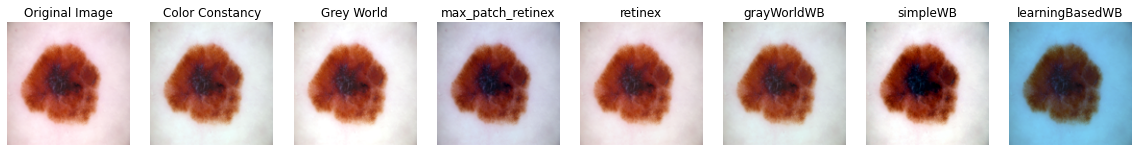

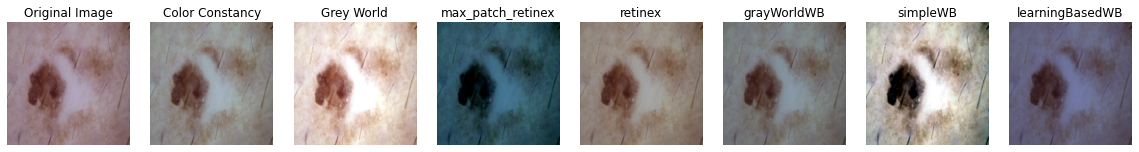

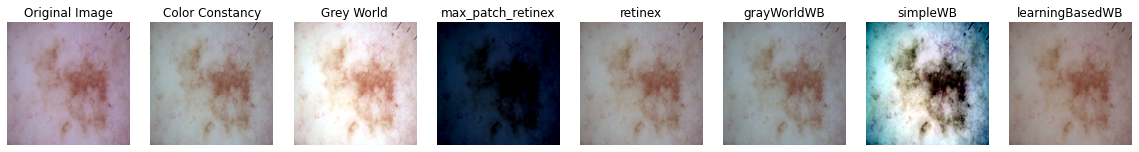

In [ ]:
n = 3
indices = np.random.choice(list(range(len(X_train))),n)
for i in range(n):
  plt.figure(figsize=(16, 3))
  ax = plt.subplot(1, 8, ((2*i)%2)+1)
  plt.imshow(X_train[indices[i]])
  plt.axis('off')
  plt.title('Original Image')
  ax = plt.subplot(1, 8, ((2*i)%2)+2)
  plt.imshow(shade_of_gray_cc(X_train[indices[i]]))
  plt.axis('off')
  plt.title('Color Constancy')
  ax = plt.subplot(1, 8, ((2*i)%2)+3)
  plt.imshow(grey_world(X_train[indices[i]]))
  plt.axis('off')
  plt.title('Grey World')
  ax = plt.subplot(1, 8, ((2*i)%2)+4)
  plt.imshow(max_patch_retinex(X_train[indices[i]]))
  plt.axis('off')
  plt.title('max_patch_retinex')
  ax = plt.subplot(1, 8, ((2*i)%2)+5)
  plt.imshow(retinex(X_train[indices[i]]))
  plt.axis('off')
  plt.title('retinex')
  ax = plt.subplot(1, 8, ((2*i)%2)+6)
  plt.imshow(grayWorldWB(X_train[indices[i]]))
  plt.axis('off')
  plt.title('grayWorldWB')
  ax = plt.subplot(1, 8, ((2*i)%2)+7)
  plt.imshow(simpleWB(X_train[indices[i]]))
  plt.axis('off')
  plt.title('simpleWB')
  ax = plt.subplot(1, 8, ((2*i)%2)+8)
  plt.imshow(learningBasedWB(X_train[indices[i]]))
  plt.axis('off')
  plt.title('learningBasedWB')
  plt.tight_layout()

In [ ]:
#apply color constancy
X_train = np.array(list(map(shade_of_gray_cc, X_train)))
X_val = np.array(list(map(shade_of_gray_cc, X_val)))

In [ ]:
X_train = preprocess_image_input(X_train, the_arch)
X_val = preprocess_image_input(X_val, the_arch)

preprocess data


#Image Augmentation

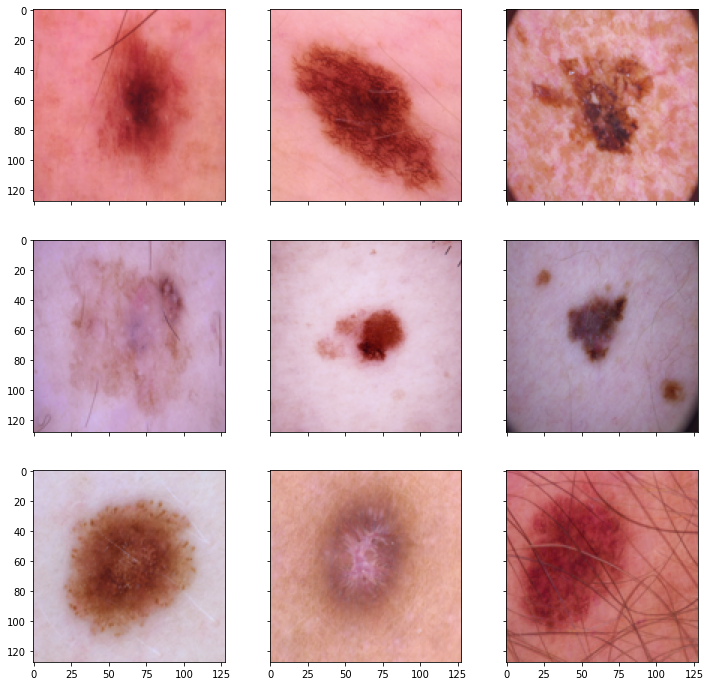

In [ ]:
#https://machinelearningmastery.com/image-augmentation-deep-learning-keras/
# create a grid of 3x3 of original images
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12,12))
for i in range(3):
    for j in range(3):
        ax[i][j].imshow(X_train[i*3+j], cmap=plt.get_cmap("gray"))
# show the plot
plt.show()

In [30]:
datagen = ImageDataGenerator(
    brightness_range=[0.7,1.3],
    rotation_range=90,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

#Training

best_model_fpath:/content/drive/MyDrive/PHD/Model/best_model_no preprocessing_under70_128px_raw.h5
Epoch 1/50
83/83 [==============================] - ETA: 0s - loss: 1.4665 - accuracy: 0.4403 - recall: 0.2293
Epoch 1: val_recall improved from -inf to 0.48187, saving model to /content/drive/MyDrive/PHD/Model/best_model_no preprocessing_under70_128px_raw.h5
83/83 [==============================] - 25s 247ms/step - loss: 1.4665 - accuracy: 0.4403 - recall: 0.2293 - val_loss: 0.8904 - val_accuracy: 0.6528 - val_recall: 0.4819 - lr: 0.0010
Epoch 2/50
83/83 [==============================] - ETA: 0s - loss: 1.2437 - accuracy: 0.5174 - recall: 0.3179
Epoch 2: val_recall improved from 0.48187 to 0.49741, saving model to /content/drive/MyDrive/PHD/Model/best_model_no preprocessing_under70_128px_raw.h5
83/83 [==============================] - 21s 251ms/step - loss: 1.2437 - accuracy: 0.5174 - recall: 0.3179 - val_loss: 0.8216 - val_accuracy: 0.6995 - val_recall: 0.4974 - lr: 0.0010
Epoch 3/50
8

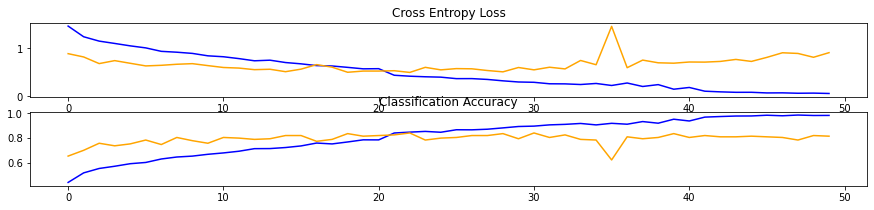

In [53]:
opt_adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
opt_SGD = SGD(learning_rate=0.001)

# define model
model = define_model_resnet()
#Callbacks
best_model_fpath = '/content/drive/MyDrive/PHD/Model/best_model_'+exp_name+'_'+dataset_name+'.h5'
#best_model_fpath = '/content/drive/MyDrive/PHD/Model/best_model_'+'no_smote_3_dense'+'_'+dataset_name+'.h5'
print("best_model_fpath:"+best_model_fpath)
mc = ModelCheckpoint(best_model_fpath, monitor='val_recall', mode='max', verbose=1, save_best_only=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_recall', patience=20, verbose=1, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=40,monitor='val_recall')
#model.summary()
hst = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), verbose=1,
                    steps_per_epoch=X_train.shape[0] // BATCH_SIZE, 
                    #callbacks=[learning_rate_reduction,early_stopping_monitor, mc])
                    callbacks=[learning_rate_reduction,mc])
# fits the model on batches with real-time data augmentation:
#hst = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
#         validation_data=(X_val, y_val),
#         steps_per_epoch=len(X_train) / BATCH_SIZE, epochs=EPOCHS, verbose=1,
#         callbacks=[learning_rate_reduction,mc])
# learning curves
summarize_diagnostics(hst)

In [54]:
#save last model
last_model_fpath = '/content/drive/MyDrive/PHD/Model/last_model_'+exp_name+'_'+dataset_name+'.h5'
#last_model_fpath = '/content/drive/MyDrive/PHD/Model/last_model_'+'no_smote_3_dense'+'_'+dataset_name+'.h5'
model.save(last_model_fpath)
print("model saved at ", last_model_fpath)

model saved at  /content/drive/MyDrive/PHD/Model/last_model_no preprocessing_under70_128px_raw.h5


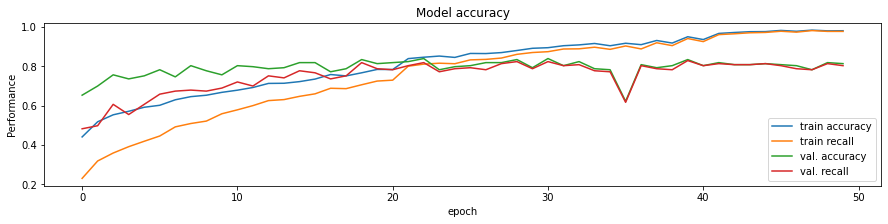

In [55]:
# summarize history for accuracy
plt.plot(hst.history['accuracy'])
plt.plot(hst.history['recall'])
plt.plot(hst.history['val_accuracy'])
plt.plot(hst.history['val_recall'])
plt.title('Model accuracy')
plt.ylabel('Performance')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'train recall', 'val. accuracy', 'val. recall'], loc='lower right')
plt.show()

#Evaluate

In [56]:
last_model_fpath = '/content/drive/MyDrive/PHD/Model/last_model_'+exp_name+'_'+dataset_name+'.h5'
#last_model_fpath = '/content/drive/MyDrive/PHD/Model/last_model_'+'smote on IS with dropout'+'_'+dataset_name+'.h5'
print(last_model_fpath)
last_model = load_model(last_model_fpath, custom_objects={'balanced_acc' : balanced_acc})
y_train_pred = last_model.predict(X_train)
y_val_pred = last_model.predict(X_val)

#print('accuracy on training',accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1)))
print('accuracy on training',accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1)))
print('balanced accuracy on training',balanced_accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1)))
print('accuracy on validation',accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1)))
print('balanced accuracy on validation',balanced_accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1)))
print('F1.5-score on validation',fbeta_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1),average='macro', beta=1.5))
print('Score on val data: ',precision_recall_fscore_support(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1), average='macro'))

/content/drive/MyDrive/PHD/Model/last_model_no preprocessing_under70_128px_raw.h5
7/7 [==============================] - 0s 35ms/step
accuracy on training 0.9945498966359707
balanced accuracy on training 0.9903838980979905
accuracy on validation 0.8134715025906736
balanced accuracy on validation 0.7320218109416716
F1.5-score on validation 0.6878065067191969
Score on val data:  (0.6640177840177841, 0.7320218109416716, 0.672778567188505, None)


In [57]:
#best_model_fpath = '/content/drive/MyDrive/PHD/Model/best_model_smote on IS far from centroid_under70_128px.h5'
best_model_fpath = '/content/drive/MyDrive/PHD/Model/best_model_'+exp_name+'_'+dataset_name+'.h5'
print('best_model_fpath: ',best_model_fpath)
best_model = load_model(best_model_fpath, custom_objects={'balanced_acc' : balanced_acc})
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)

print('accuracy on training',accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1)))
print('balanced accuracy on training',balanced_accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1)))
print('accuracy on validation',accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1)))
print('balanced accuracy on validation',balanced_accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1)))
print('F1.5-score on validation',fbeta_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1),average='macro', beta=1.5))
print('Score on val data: ',precision_recall_fscore_support(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1), average='macro'))

best_model_fpath:  /content/drive/MyDrive/PHD/Model/best_model_no preprocessing_under70_128px_raw.h5
7/7 [==============================] - 0s 35ms/step
accuracy on training 0.969930464198459
balanced accuracy on training 0.9473510646224831
accuracy on validation 0.8341968911917098
balanced accuracy on validation 0.7423088525875983
F1.5-score on validation 0.7332207373924174
Score on val data:  (0.7510025062656641, 0.7423088525875983, 0.7331944335246482, None)


In [58]:
print(exp_name,dataset_name)

no preprocessing under70_128px_raw


#Color Feature

In [ ]:
y_train_decode = np.argmax(y_train, axis=1)
y_train_pred_decode = np.argmax(y_train_pred, axis=1)
tp_0_train_IS = X_train[np.logical_and(y_train_decode==0,y_train_pred_decode==0)]
print('tp_0_train_IS: ',tp_0_train_IS.shape)
fn_0_train_IS = X_train[np.logical_and(y_train_decode==0,y_train_pred_decode!=0)]
print('fn_0_train_IS: ',fn_0_train_IS.shape)
#tp_0_train_FS_1 = X_train_fs_1[np.logical_and(y_train_decode==0,y_train_pred_decode==0)]
#print('tp_0_train_FS_1: ',tp_0_train_FS_1.shape)
#fn_0_train_FS_1 = X_train_fs_1[np.logical_and(y_train_decode==0,y_train_pred_decode!=0)]
#print('fn_0_train_FS_1: ',fn_0_train_FS_1.shape)
#tp_0_train_FS_2 = X_train_fs_2[np.logical_and(y_train_decode==0,y_train_pred_decode==0)]
#print('tp_0_train_FS_2: ',tp_0_train_FS_2.shape)
#fn_0_train_FS_2 = X_train_fs_2[np.logical_and(y_train_decode==0,y_train_pred_decode!=0)]
#print('fn_0_train_FS_2: ',fn_0_train_FS_2.shape)

y_val_decode = np.argmax(y_val, axis=1)
y_val_pred_decode = np.argmax(y_val_pred, axis=1)
tp_0_val_IS = X_val[np.logical_and(y_val_decode==0,y_val_pred_decode==0)]
print('tp_0_val_IS: ',tp_0_val_IS.shape)
fn_0_val_IS = X_val[np.logical_and(y_val_decode==0,y_val_pred_decode!=0)]
print('fn_0_val_IS: ',fn_0_val_IS.shape)
#tp_0_val_FS_1 = X_val_fs_1[np.logical_and(y_val_decode==0,y_val_pred_decode==0)]
#print('tp_0_val_FS_1: ',tp_0_val_FS_1.shape)
#fn_0_val_FS_1 = X_val_fs_1[np.logical_and(y_val_decode==0,y_val_pred_decode!=0)]
#print('fn_0_val_FS_1: ',fn_0_val_FS_1.shape)
#tp_0_val_FS_2 = X_val_fs_2[np.logical_and(y_val_decode==0,y_val_pred_decode==0)]
#print('tp_0_val_FS_2: ',tp_0_val_FS_2.shape)
#fn_0_val_FS_2 = X_val_fs_2[np.logical_and(y_val_decode==0,y_val_pred_decode!=0)]
#print('fn_0_val_FS_2: ',fn_0_val_FS_2.shape)

tp_0_train_IS:  (2009, 128, 128, 3)
fn_0_train_IS:  (2, 128, 128, 3)
tp_0_val_IS:  (5, 128, 128, 3)
fn_0_val_IS:  (3, 128, 128, 3)


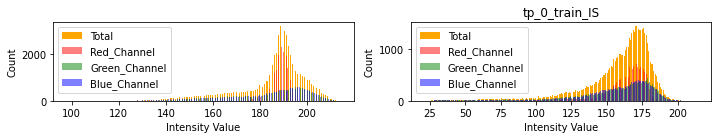

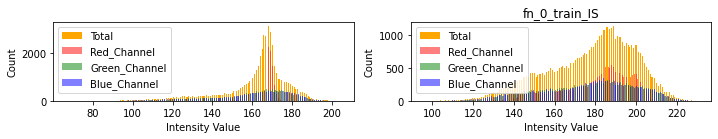

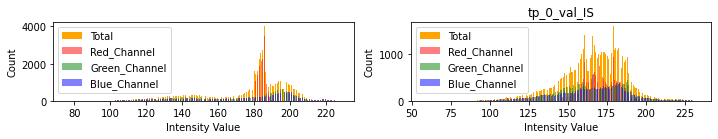

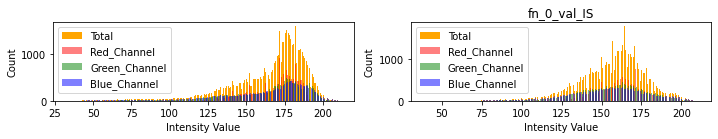

In [ ]:
data_str = ["tp_0_train_IS", "fn_0_train_IS", "tp_0_val_IS", "fn_0_val_IS"]#, "tp_0_train_FS_1", "fn_0_train_FS_1", "tp_0_train_FS_2", "fn_0_train_FS_2", "tp_0_val_FS_1", "fn_0_val_FS_1", "tp_0_val_FS_2", "fn_0_val_FS_2"]
data_obj = [tp_0_train_IS, fn_0_train_IS, tp_0_val_IS, fn_0_val_IS]#, tp_0_train_FS_1, fn_0_train_FS_1, tp_0_train_FS_2, fn_0_train_FS_2, tp_0_val_FS_1, fn_0_val_FS_1, tp_0_val_FS_2, fn_0_val_FS_2]
for idx, data in enumerate(list(map(restore_original_image_from_array, data_obj))):
  plt.figure(figsize=(20, 20))
  for i in range(2):
    image = data[i]
    ax = plt.subplot(12, 4, i +1)
    if idx < 4:
      _ = plt.hist(image.ravel(), bins = 256, color = 'orange', )
      _ = plt.hist(image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
      _ = plt.hist(image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
      _ = plt.hist(image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
      _ = plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
    else:
      _ = plt.hist(image[image!=0].ravel(), bins = 256, color = 'orange', )
      _ = plt.legend(['Total'])
    _ = plt.xlabel('Intensity Value')
    _ = plt.ylabel('Count')
    if i == 1:
      plt.title(data_str[idx])
  plt.tight_layout()
  plt.show()

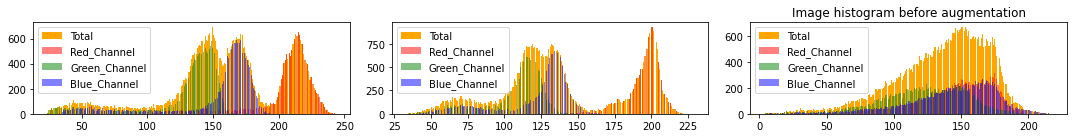

In [ ]:
#3 random image histogram before augmentation
n = 3
indices = np.random.choice(list(range(len(X_train))),n)
plt.figure(figsize=(20, 20))
for i in range(n):
  image = X_train[indices[i]]
  ax = plt.subplot(12, 4, i +1)
  _ = plt.hist(image.ravel(), bins = 256, color = 'orange', )
  _ = plt.hist(image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
  _ = plt.hist(image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
  _ = plt.hist(image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
  _ = plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.title('Image histogram before augmentation')
plt.tight_layout()
plt.show()

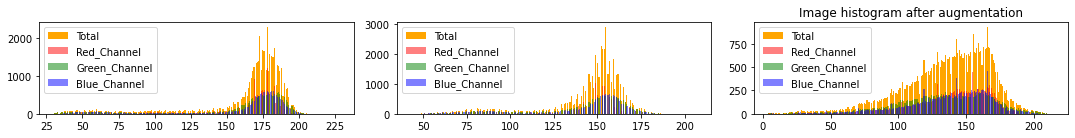

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(n):
  image = X_train[indices[i]]
  ax = plt.subplot(12, 4, i +1)
  _ = plt.hist(image.ravel(), bins = 256, color = 'orange', )
  _ = plt.hist(image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
  _ = plt.hist(image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
  _ = plt.hist(image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
  _ = plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.title('Image histogram after augmentation')
plt.tight_layout()
plt.show()

#Grad-Cam

In [ ]:
from tensorflow.keras.models import Model



def GradCam(model, img_array, layer_name, eps=1e-8):
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model
    

    Args:
      model: tf model
      img_array: (img_width x img_width) numpy array
      layer_name: str


    Returns 
      uint8 numpy array with shape (img_height, img_width)

    '''

    gradModel = Model(
			inputs=[model.inputs],
			outputs=[model.get_layer(layer_name).output,
				model.output])
    
    with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
      inputs = tf.cast(img_array, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, 0]
		# use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
    # grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    # heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
    return heatmap


def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize=False):
    
    '''
    Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.
    

    Args:
      image: (img_width x img_height x 3) numpy array
      grad-cam heatmap: (img_width x img_width) numpy array
      threshold: float
      emphasize: boolean

    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']       

In [ ]:
import cv2

In [ ]:
fp_0[0].shape

(128, 128, 3)

In [ ]:
## Grad-CAM heatmap for the last convolutional layer in the model, Conv_1

layer_name = 'resnet50'
grad_cam=GradCam(last_model,np.expand_dims(fp_0[0], axis=0),layer_name)
grad_cam_superimposed = superimpose(fp_0[0], grad_cam, 0.5, emphasize=True)


plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(fp_0[0], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('Conv_1 Grad-CAM heat-map')
plt.tight_layout()




#Grad-Cam 2

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm


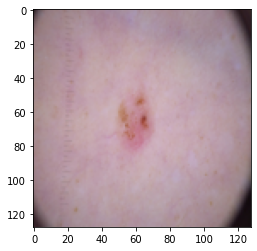

In [ ]:
#model_builder = keras.applications.xception.Xception
img_size = (128, 128)
#preprocess_input = keras.applications.xception.preprocess_input
#decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "conv5_block3_out"

# The local path to our target image
#img_path = keras.utils.get_file(
#    "african_elephant.jpg", "https://i.imgur.com/Bvro0YD.png"
#)

#display(Image(fp_0[0]))
plt.imshow(restore_original_image_from_array(X_val[0], data_format='channels_last'))
plt.show()


In [ ]:

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


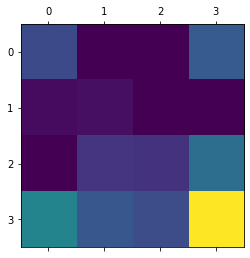

In [ ]:
# Prepare image
#img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
#model = model_builder(weights="imagenet")

# Remove last layer's softmax
#model.layers[-1].activation = None

# Print what the top predicted class is
#preds = model.predict(img_array)
#print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(np.expand_dims(X_val[0], axis=0), last_model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()


In [ ]:

def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
#    img = keras.preprocessing.image.load_img(img_path)
#    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

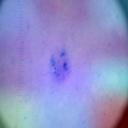

In [ ]:
save_and_display_gradcam(X_val[0], heatmap)

#Grad-Cam 3

In [ ]:
y_val_decode = np.argmax(y_val, axis=1)
y_val_pred_decode = np.argmax(y_val_pred, axis=1)
fp_0 = X_val[np.logical_and(y_val_decode==2,y_val_pred_decode==0)]
print(fp_0.shape)
fp_2 = X_val[np.logical_and(y_val_decode==0,y_val_pred_decode==2)]
print(fp_2.shape)
fp_0_df = df1[np.logical_and(y_val_decode==2,y_val_pred_decode==0)]
fp_2_df = df1[np.logical_and(y_val_decode==0,y_val_pred_decode==2)]

tp_0 = X_val[np.logical_and(y_val_decode==0,y_val_pred_decode==0)]
print(tp_0.shape)

(1, 128, 128, 3)
(2, 128, 128, 3)
(4, 128, 128, 3)


In [ ]:
def decode_prediction(pred):
  # This function thresholds a probability to produce a prediction
  pred = tf.where(pred < 0.5, 0, 1)
  return pred.numpy()

In [ ]:
import cv2

1/1 [==============================] - 0s 42ms/step


Text(0.5, 1.0, 'AKIEC')

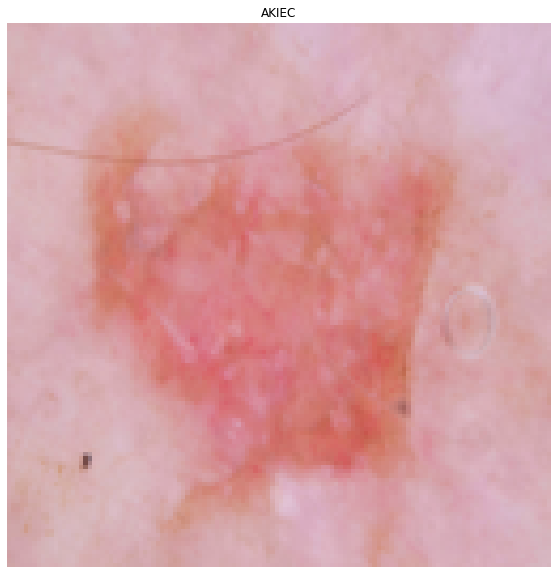

In [ ]:
img = restore_original_image_from_array(tp_0[0], data_format='channels_last')
label = 0#y_val[0]
class_info = {0:'AKIEC',1:'BCC',2:'BKL',3:'DF',4:'Melanoma',5:'Nevi',6:'Vasc'}

pred_raw = model.predict(np.expand_dims(img, axis=0))[0][0]
pred = decode_prediction(pred_raw)
pred_label = class_info[pred]

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.title(class_info[label])

In [ ]:
from tensorflow.keras.models import Model



def GradCam(model, img_array, layer_name, eps=1e-8):
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model
    

    Args:
      model: tf model
      img_array: (img_width x img_width) numpy array
      layer_name: str


    Returns 
      uint8 numpy array with shape (img_height, img_width)

    '''

    gradModel = Model(
			inputs=[model.inputs],
			outputs=[model.get_layer(layer_name).output,
				model.output])
    
    with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
      inputs = tf.cast(img_array, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, 0]
		# use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
    # grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    # heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
    return heatmap


def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize=False):
    
    '''
    Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.
    

    Args:
      image: (img_width x img_height x 3) numpy array
      grad-cam heatmap: (img_width x img_width) numpy array
      threshold: float
      emphasize: boolean

    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb

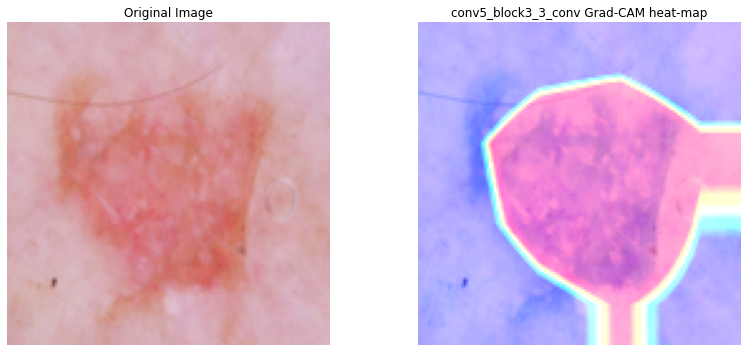

In [ ]:
## Grad-CAM heatmap for the last convolutional layer in the model, Conv_1

layer_name = 'conv5_block3_3_conv'
grad_cam=GradCam(model,np.expand_dims(img, axis=0),layer_name)
grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=True)


plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title(layer_name+' Grad-CAM heat-map')
plt.tight_layout()




In [ ]:
## Gather all convolution and activation layers from the model
## With these layers, we can explore grad-cam heatmaps for more layers in the model

conv2D_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and isinstance(layer, tf.keras.layers.Conv2D)]
activation_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and layer.__class__.__name__ == 'ReLU']
all_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and (layer.__class__.__name__ == 'ReLU' or isinstance(layer, tf.keras.layers.Conv2D))]
print(len(conv2D_layers),len(activation_layers),len(all_layers))

53 0 53


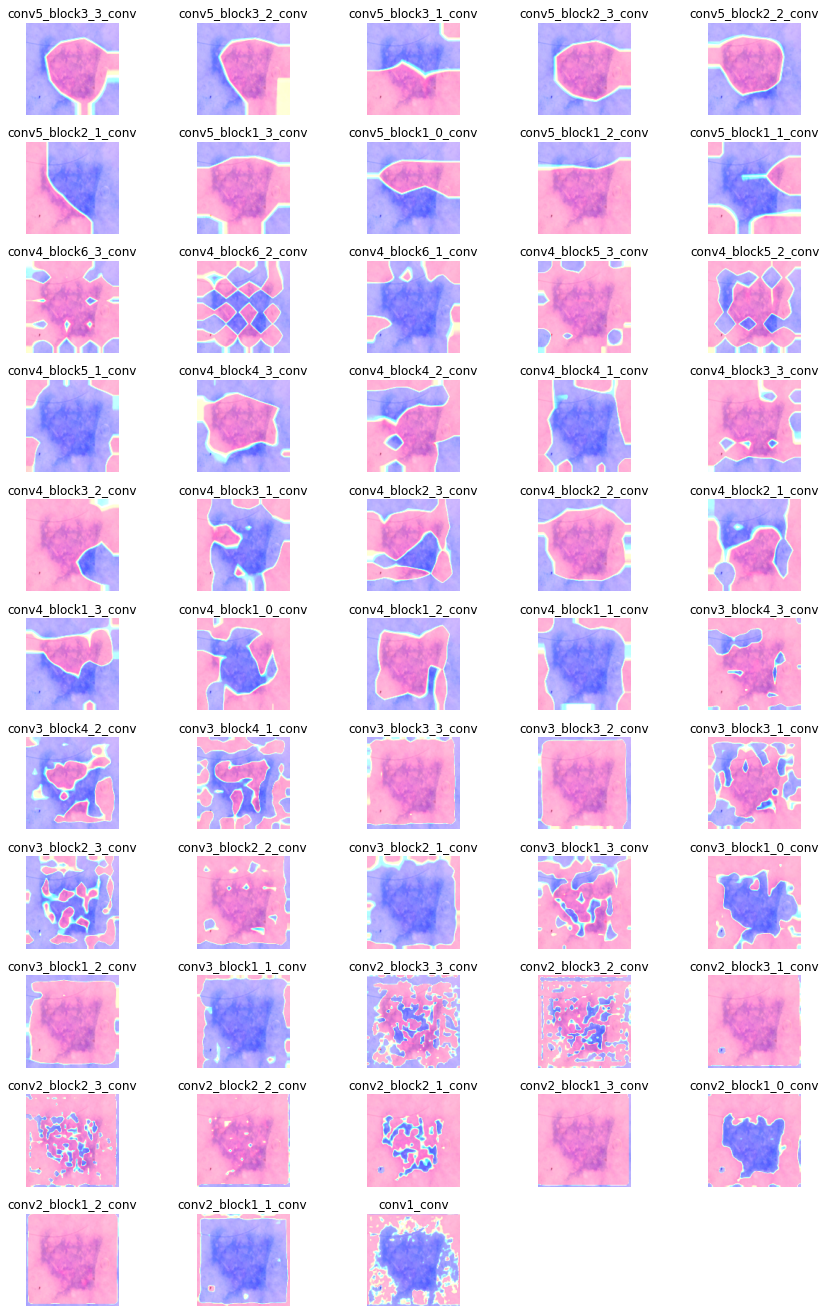

In [ ]:
## Visualizing Convolution layers
plt.figure(figsize=(12, 20))
for i, layer in enumerate(conv2D_layers):
  grad_cam = GradCam(model, np.expand_dims(img, axis=0), layer)
  grad_cam_emphasized = superimpose(img, grad_cam, 0.5, emphasize=True)
  ax = plt.subplot(12, 5, i +1)
  plt.imshow(grad_cam_emphasized)
  plt.title(layer)
  plt.axis("off")
plt.tight_layout()


In [ ]:
def fuse_layers(layers, model, img, emphasize=False):
  '''
    Fuses grad-cam heatmaps from a list of model layers into a single heatmap
    and superimposes the heatmap onto an image.

    Args:
      layers: list of strings
      model: tf model
      img: (img_width x img_height x 3) numpy array


    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
  cams = []
  for layer in layers:
    cam = GradCam(model, np.expand_dims(img, axis=0), layer)
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    cams.append(cam)

  fused = np.mean(cams, axis=0)
  superimposed = superimpose(img, fused, 0.5, emphasize=emphasize)

  return superimposed


In [ ]:
## Using the fuse_layers function, lets fuse together all layers in the model

fused = fuse_layers(all_layers, model, img, True)

Text(0.5, 1.0, 'All layers Grad-CAM heat-map')

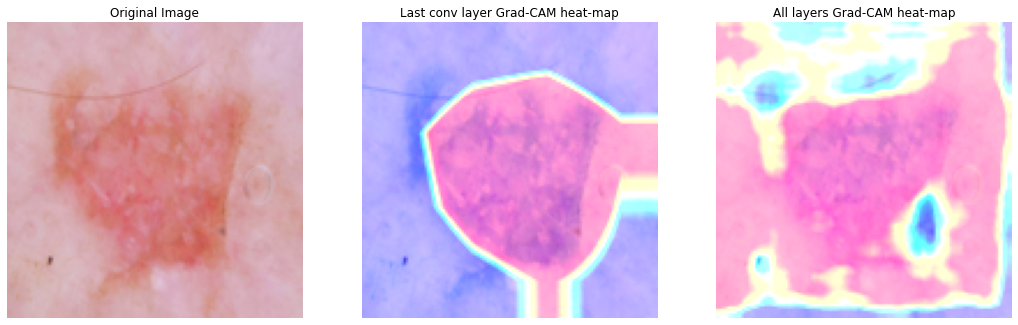

In [ ]:
## We can see how fusing together all layers improves upon the Grad-CAM from the last
## convolutional layer in the model

plt.figure(figsize=(18, 8))
ax = plt.subplot(1, 3, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 3, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('Last conv layer Grad-CAM heat-map')
ax = plt.subplot(1, 3, 3)
plt.imshow(fused)
plt.axis('off')
plt.title('All layers Grad-CAM heat-map')


In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']       

#UMAP

In [ ]:
pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.8 MB/s 
     |████████████████████████████████| 1.1 MB 10.5 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=c388b789acfcdc1486018412de8277ca125a4f9b481183c60cd302b06cc549f4
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55509 sha256=0694c5f6e142f99e9dbabfd3261be2672262c1d81f116a118d3cc2f6a42a5814
  Stored in directory: /root/.cache/pip/wheels/19/bc/eb/974072a56a7082a302f8b4be1ad6d21bf5019235c2eff65928
Successfully built umap-learn pynndescent


In [ ]:
import umap

In [ ]:
y_train_decode = np.argmax(y_train, axis=1)
y_val_decode = np.argmax(y_val, axis=1)

In [ ]:
#import umap
reducer = umap.UMAP(n_neighbors=15,random_state=42)
#mapping = reducer.fit(np.concatenate((X_train_fs,X_val_fs), axis=0))
#embedding = reducer.transform(np.concatenate((X_train_fs,X_val_fs), axis=0))
mapping = reducer.fit(X_train.reshape(-1,1))
embedding = mapping.transform(X_train.reshape(-1,1))
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

In [ ]:
test_embedding = mapping.transform(X_val.reshape(-1,1))
test_embedding.shape

In [ ]:
plt.scatter(embedding[:, 0], embedding[:, 1], s= 5, c=np.argmax(y_train, axis=1), cmap='Spectral')
#plt.scatter(test_embedding[:, 0], test_embedding[:, 1], s= 25, c=np.argmax(y_val, axis=1), cmap='Spectral', marker='X')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(num_classes+1)-0.5).set_ticks(np.arange(num_classes))
plt.title('Embedding of the Training set by UMAP', fontsize=24);

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)

In [ ]:
#plt.scatter(embedding[:, 0], embedding[:, 1], s= 5, c=np.argmax(y_train, axis=1), cmap='Spectral')
plt.scatter(test_embedding[:, 0], test_embedding[:, 1], s= 25, c=np.argmax(y_val, axis=1), cmap='Spectral', marker='X')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(num_classes+1)-0.5).set_ticks(np.arange(num_classes))
plt.title('Embedding of the Test set by UMAP', fontsize=24);

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)

#temp

In [ ]:
y_val_decode = np.argmax(y_val, axis=1)
y_val_pred_decode = np.argmax(y_val_pred, axis=1)
fp_0 = X_val[np.logical_and(y_val_decode==2,y_val_pred_decode==0)]
print(fp_0.shape)
fp_2 = X_val[np.logical_and(y_val_decode==0,y_val_pred_decode==2)]
print(fp_2.shape)
fp_0_df = df1[np.logical_and(y_val_decode==2,y_val_pred_decode==0)]
fp_2_df = df1[np.logical_and(y_val_decode==0,y_val_pred_decode==2)]

tp_0 = X_val[np.logical_and(y_val_decode==0,y_val_pred_decode==0)]
tp_2 = X_val[np.logical_and(y_val_decode==2,y_val_pred_decode==2)]
print(tp_0.shape)
print(tp_2.shape)

(1, 128, 128, 3)
(3, 128, 128, 3)
(4, 128, 128, 3)
(18, 128, 128, 3)


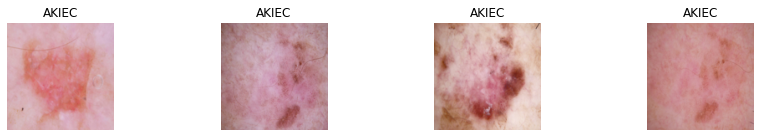

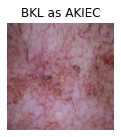

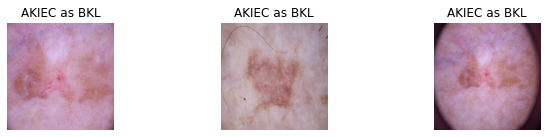

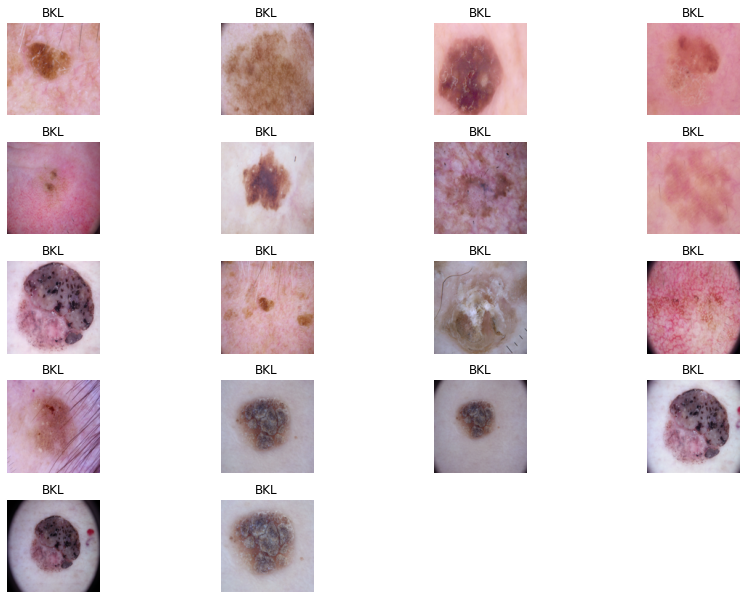

In [ ]:
plt.figure(figsize=(12, 20))
for i in range(4):
  ax = plt.subplot(12, 4, i +1)
  plt.imshow(restore_original_image_from_array(tp_0[i], data_format='channels_last'))
  plt.title("AKIEC")
  plt.axis("off")
plt.tight_layout()

plt.figure(figsize=(12, 20))
for i in range(1):
  ax = plt.subplot(12, 4, i +1)
  plt.imshow(restore_original_image_from_array(fp_0[i], data_format='channels_last'))
  plt.title("BKL as AKIEC")
  plt.axis("off")
plt.tight_layout()

plt.figure(figsize=(12, 20))
for i in range(3):
  ax = plt.subplot(12, 4, i +1)
  plt.imshow(restore_original_image_from_array(fp_2[i], data_format='channels_last'))
  plt.title("AKIEC as BKL")
  plt.axis("off")
plt.tight_layout()

plt.figure(figsize=(12, 20))
for i in range(18):
  ax = plt.subplot(12, 4, i +1)
  plt.imshow(restore_original_image_from_array(tp_2[i], data_format='channels_last'))
  plt.title("BKL")
  plt.axis("off")
plt.tight_layout()

#Cont

In [ ]:
pip install umap-learn[plot]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.2 MB 10.3 MB/s 
     |████████████████████████████████| 76 kB 5.6 MB/s 
  Created wheel for datashape: filename=datashape-0.5.2-py3-none-any.whl size=59438 sha256=4852c7c0817e731d3d16dcade29472eca881a2d62cbafacba9e3efc0af23b022
  Stored in directory: /root/.cache/pip/wheels/b5/b7/80/333a5c3312ed4cd54f5d5b869868c14e0c6002cb5c7238b52d
Successfully built datashape


In [ ]:
hover_data = pd.DataFrame({'index':np.arange(14077),
                           'label':np.argmax(y_train, axis=1)})
hover_data['item'] = hover_data.label.map(
    {
        0:'AKIEC',
        1:'BCC',
        2:'BKL',
        3:'DF',
        4:'Melanoma',
        5:'Nevi',
        6:'Vasc',
    }
)

In [ ]:
#FOR X_VAL
hover_data = pd.DataFrame({'index':np.arange(y_val.shape[0]),
                           'label':np.argmax(y_val, axis=1)})
hover_data['item'] = hover_data.label.map(
    {
        0:'AKIEC',
        1:'BCC',
        2:'BKL',
        3:'DF',
        4:'Melanoma',
        5:'Nevi',
        6:'Vasc',
    }
)

In [ ]:
import umap.plot

In [ ]:
umap.plot.output_notebook()

In [ ]:
p = umap.plot.interactive(mapping, labels=np.argmax(y_train, axis=1), hover_data=hover_data, point_size=2)
umap.plot.show(p)

ValueError: ignored

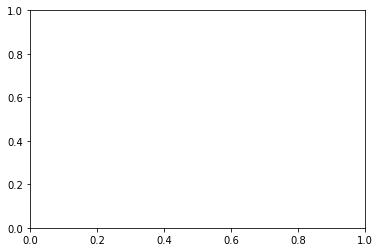

In [ ]:
plt.scatter(embedding[:, 0], embedding[:, 1], s= 5, c=np.argmax(y_train, axis=1), cmap='Spectral')
plt.scatter(test_embedding[:, 0], test_embedding[:, 1], s= 25, c=np.argmax(y_val, axis=1), cmap='Spectral', marker='X')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(8)-0.5).set_ticks(np.arange(7))
plt.title('Embedding of the test set by UMAP', fontsize=24);

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)

#Cut-off

In [ ]:
df_val_pred = pd.DataFrame(y_val_pred, columns = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'])

In [ ]:
numbers = [float(x)/40 for x in range(11)]
for i in numbers:
    df_val_pred[i]= df_val_pred.MEL.map(lambda x: 1 if x > i else 0)
df_val_pred.head()

,AKIEC,BCC,BKL,DF,MEL,NV,VASC,0.0,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225,0.25
0,3.090921e-07,9.996200e-01,2.427639e-04,6.437593e-05,1.916536e-05,5.326564e-05,1.437628e-07,1,0,0,0,0,0,0,0,0,0,0
1,1.375006e-15,1.271707e-15,7.886792e-10,3.873745e-13,6.200786e-07,9.999994e-01,6.723950e-14,1,0,0,0,0,0,0,0,0,0,0
2,2.292977e-02,9.769607e-01,3.134560e-05,3.750155e-06,1.027365e-08,5.761424e-09,7.435224e-05,1,0,0,0,0,0,0,0,0,0,0
3,3.805227e-16,1.073426e-13,1.566999e-07,2.658983e-14,4.196105e-05,9.999579e-01,1.634144e-08,1,0,0,0,0,0,0,0,0,0,0
4,2.687866e-13,2.825541e-15,1.501939e-08,2.123309e-14,5.977655e-08,9.999999e-01,1.584354e-11,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
y_val_true= [1 if x == 4 else 0 for x in np.argmax(y_val, axis=1)]

In [ ]:
#num = [0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
cutoff_df = pd.DataFrame( columns = ['Probability','Accuracy','Sensitivity','Specificity'])
for i in numbers:
    cm1 = confusion_matrix(y_val_true, df_val_pred[i])
    total1=sum(sum(cm1))
    Accuracy = (cm1[0,0]+cm1[1,1])/total1
    Specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    Sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,Accuracy,Sensitivity,Specificity]

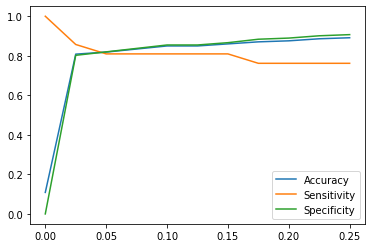

In [ ]:
cutoff_df[['Accuracy','Sensitivity','Specificity']].plot()

plt.show()

In [ ]:
i = 0.025
cm1 = confusion_matrix(y_val_true, df_val_pred[i])
total1=sum(sum(cm1))
Accuracy = (cm1[0,0]+cm1[1,1])/total1
Specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
Sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])

In [ ]:
print('Accuracy: ', Accuracy)
print('Sensitivity: ', Sensitivity)
print('Specificity: ', Specificity)

Accuracy:  0.8082901554404145
Sensitivity:  0.8571428571428571
Specificity:  0.8023255813953488


In [ ]:
#change melanoma flag back to 4
df_val_pred[df_val_pred[i] == 1] = 4
#decode one-hot y_val_pred while use cut-off melanoma data
condition = df_val_pred[i] == 4
y_val_pred2 = np.where(condition, df_val_pred[i], np.argmax(y_val_pred, axis=1))

In [ ]:
print('Accuracy: ',accuracy_score(np.argmax(y_val, axis=1), y_val_pred2))
print('Balanced accuracy: ',balanced_accuracy_score(np.argmax(y_val, axis=1), y_val_pred2))

Accuracy:  0.7150259067357513
Balanced accuracy:  0.7596124259016246


#Confusion Metric on Validation Set

In [59]:
#Get the confusion matrix
#cf_matrix = confusion_matrix(np.argmax(y_val, axis=1), y_val_pred2)#FOR CUT-OFF
cf_matrix = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1))
print(cf_matrix)

[[  2   3   2   0   1   0   0]
 [  1  14   0   0   0   0   0]
 [  1   1  15   0   3   2   0]
 [  0   0   0   1   0   0   0]
 [  2   0   2   0  16   1   0]
 [  0   6   1   0   5 111   0]
 [  0   1   0   0   0   0   2]]


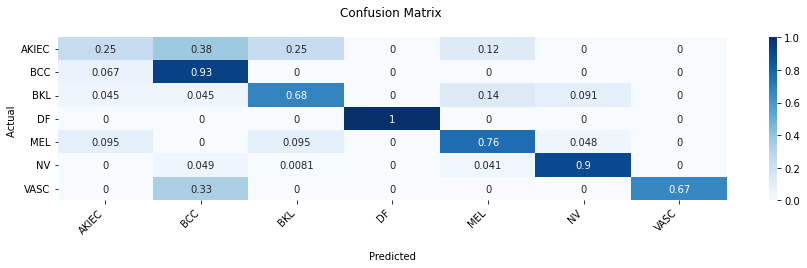

In [60]:
ax = sns.heatmap(cf_matrix / cf_matrix.sum(axis=1, keepdims=True), annot=True, 
            cmap='Blues')

ax.set_title('Confusion Matrix \n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'])
ax.yaxis.set_ticklabels(['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'])

plt.rcParams["figure.figsize"] = (15,3)

## Display the visualization of the Confusion Matrix.
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.show()

In [61]:
print(exp_name, dataset_name)

no preprocessing under70_128px_raw


#Testing

In [ ]:
path = '/content/drive/MyDrive/PHD/Datasets/isic2018/'
df_test = pd.read_pickle(path+"isic2018_test_"+dataset_name+".pkl")
X_test = df_test.loc[:, df_test.columns != 'y_train'].to_numpy()
X_test = X_test.reshape(-1,IMAGE_W,IMAGE_H,3)
X_test.shape

(1512, 128, 128, 3)

In [62]:
dir_test = '/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Test_Input/'
filepaths = sorted( filter( lambda x: (os.path.isfile(os.path.join(dir_test, x))) and (x.endswith('.jpg')),
                        os.listdir(dir_test) ) )

In [63]:
#ONLY FOR LOADING DATASET FROM CSV
df_test = pd.DataFrame(filepaths, columns =['image'])
df_test['FilePaths'] = dir_test + df_test['image']

In [64]:
df_test['image_px'] = df_test['FilePaths'].map(lambda x: np.asarray(Image.open(x).resize(IMG_SIZE)))

In [65]:
X_test = np.asarray(df_test['image_px'].tolist())
print(np.array(X_test).shape)

(1512, 128, 128, 3)


In [37]:
#preprocess
X_test = preprocess_image_input(X_test)

preprocess data


In [ ]:
df3 = pd.DataFrame(X_test.reshape(X_test.shape[0],-1))
df3.to_pickle(path+"isic2018_test_"+dataset_name+".pkl")

Calculate y_pred from training and testing for analysis

In [ ]:
#FOR MAKING FEATURE SPACE DATA
X_test = model1.predict(X_test)
X_test.shape

(1512, 2048)

In [66]:
# predicting
#CHANGE THE MODEL IF NECESSARY
Y_pred2 = best_model.predict(X_test)
#Y_pred2 = model2.predict(X_test)
print("Y_pred2", Y_pred2.shape)

48/48 [==============================] - 2s 37ms/step
Y_pred2 (1512, 7)


In [67]:
df_pred = pd.DataFrame(Y_pred2, columns = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'])
df_pred['image'] = df_test['FilePaths'].map(lambda x: x.replace(dir_test, '').replace('.jpg', ''))
df_pred = df_pred[['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']]
df_pred.set_index("image", inplace = True)

In [ ]:
#update MEL data using cut-off value
df_pred.MEL[df_pred.MEL > i] = 1

In [ ]:
df_pred.loc[df_pred.MEL > i, ['NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']] = 0

In [68]:
df_pred.to_csv('/content/drive/MyDrive/PHD/Datasets/isic2018/response_'+exp_name+'_'+dataset_name+'.csv')
print("response saved!")

response saved!


In [69]:
print(exp_name, dataset_name, "result: 0.537")

no preprocessing under70_128px_raw result: 0.537


#Exp

In [ ]:
input_tensor = Input(shape=(IMAGE_H, IMAGE_W, 3))
base_model = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)
x = base_model(input_tensor, training=False)
x = Attention(2048,2048,7,8)(x)
x = GlobalAveragePooling2D()(x)
res50 = Model(inputs=input_tensor, outputs=x)

In [ ]:
#Train i-last layer
# summarize feature map shapes
for i in range(len(model.layers)):
    layer = model.layers[i]
    # summarize output shape
    print(i, layer.name, layer.output.shape)

In [ ]:
X_train = res50.predict(X_train)
X_val = res50.predict(X_val)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print('Counter train data: ', Counter(np.argmax(y_train, axis=1)))
print('Counter val data: ', Counter(np.argmax(y_val, axis=1)))

In [ ]:
X_train, y_train = SMOTE_Data2(X_train, y_train, True)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print('Counter train data: ', Counter(np.argmax(y_train, axis=1)))
print('Counter val data: ', Counter(np.argmax(y_val, axis=1)))

#Attention

In [ ]:
import tensorflow as tf
import tensorflow.keras as tk
from tensorflow.keras.layers import Conv2D,MaxPooling2D,AveragePooling2D,BatchNormalization,Add,ZeroPadding2D,Flatten,Dense,Input,LeakyReLU,Softmax,ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import numpy as np
import pickle
import numpy as np
from PIL import Image

class Attention(tk.layers.Layer):
    
    def __init__(self,input_channels,output_channel,kernel_size,groups):
        super().__init__()
        self.input_channels = input_channels
        self.output_channel = output_channel    
        self.kernel_size = kernel_size
        self.stride = 1
        self.groups = groups

        assert output_channel % groups == 0
        
        self.rel_h = tk.backend.variable(lambda : tk.backend.truncated_normal((1,1,kernel_size,1,output_channel//2),stddev = 0.1)) 
        #output_channels//2 is the number of channels on which the relative position will be considered,1 denotes the number of those filters and the one after that too and (kernel_size,1) denotes the size of that filter
        self.rel_w = tk.backend.variable(lambda : tk.backend.truncated_normal((1,1,1,kernel_size,output_channel//2),stddev = 0.1)) 

        self.key_weights = Conv2D(self.output_channel,kernel_size = 1,strides = self.stride)
        self.query_weights = Conv2D(self.output_channel,kernel_size = 1,strides = self.stride)
        self.value_weights = Conv2D(self.output_channel,kernel_size = 1,strides = self.stride)

    def call(self,x):
        
        batch,height,width,channels = x.shape
        x_padded = ZeroPadding2D(padding=(self.kernel_size//2,self.kernel_size//2))(x)
        query = self.query_weights(x)
        value = self.value_weights(x_padded)
        key = self.key_weights(x_padded)
        #key,query and value will have the shape of (batch,height,width,depth)
        keys = tf.image.extract_patches(images = key,sizes = [1,self.kernel_size,self.kernel_size,1],strides = [1,self.stride,self.stride,1],rates = [1,1,1,1], padding = "VALID")
        value = tf.image.extract_patches(images = value,sizes = [1,self.kernel_size,self.kernel_size,1],strides = [1,self.stride,self.stride,1],rates = [1,1,1,1], padding = "VALID")
        no_of_kernels = key.shape[-2] - self.kernel_size + 1
        keys = tf.reshape(keys,shape = (-1,no_of_kernels, no_of_kernels,self.kernel_size,self.kernel_size,self.output_channel))
        key_split_h,key_split_w = tf.split(keys,num_or_size_splits = 2,axis = -1)
        key_with_rel = tk.layers.concatenate([key_split_h + self.rel_h,key_split_w + self.rel_w],axis = -1) 
        
        #reshaping the query and key
        key_with_rel = tf.reshape(key_with_rel,(-1,self.groups,no_of_kernels,no_of_kernels,self.kernel_size*self.kernel_size,self.output_channel//self.groups))
        query  = tf.reshape(query,(-1,self.groups,no_of_kernels,no_of_kernels,1,self.output_channel//self.groups))        
        value = tf.reshape(value,(-1,self.groups,no_of_kernels,no_of_kernels,self.kernel_size*self.kernel_size,self.output_channel//self.groups))
        
        #multiplication  of key and query
        #assert key_with_rel.shape == query.shape        
        key_prod_query = query*key_with_rel
        
        # Now the function is passed through the softmax and is multiplied with the values
        s = Softmax(axis = -2)(key_prod_query)
        y = tf.einsum('bnchwk,bnchwk->bnchk',s,value)
        y = tf.reshape(y,(-1,height,width,self.output_channel))
        return y

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            "input_channels": self.input_channels, 
            "output_channel": self.output_channel, 
            "kernel_size": self.kernel_size, 
            "stride": self.stride, 
            "groups": self.groups, 
            "rel_h": self.rel_h, 
            "rel_w": self.rel_w, 
            "key_weights": self.key_weights, 
            "query_weights": self.query_weights, 
            "value_weights": self.value_weights
        })
        return config


AttributeError: ignored

#Oversampling on feature map level

In [ ]:
#CHANGE THIS
model = best_model

In [ ]:
for i in range(len(model.layers)):
  layer = model.layers[i]
  print(i, layer.name, layer.output_shape, layer.trainable)

0 input_1 [(None, 128, 128, 3)] True
1 resnet50 (None, 4, 4, 2048) True
2 global_average_pooling2d (None, 2048) True
3 flatten (None, 2048) True
4 dropout (None, 2048) True
5 dense (None, 1024) True
6 dropout_1 (None, 1024) True
7 dense_1 (None, 512) True
8 dense_2 (None, 7) True


In [ ]:
# redefine model to output right after the first hidden layer
end = 7
model1 = Model(inputs=model.inputs, outputs=model.layers[end].output)

In [ ]:
# get feature map for first hidden layer
X_train = model1.predict(X_train)
X_val = model1.predict(X_val)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print('Counter train data: ', Counter(np.argmax(y_train, axis=1)))
print('Counter val data: ', Counter(np.argmax(y_val, axis=1)))

7/7 [==============================] - 0s 28ms/step
(14077, 512)
(14077, 7)
(193, 512)
(193, 7)
Counter train data:  Counter({0: 2011, 1: 2011, 2: 2011, 3: 2011, 4: 2011, 6: 2011, 5: 2011})
Counter val data:  Counter({5: 123, 2: 22, 4: 21, 1: 15, 0: 8, 6: 3, 3: 1})


In [ ]:
path = '/content/drive/MyDrive/PHD/Datasets/isic2018/'
df1 = pd.DataFrame(X_train_fs.reshape(X_train_fs.shape[0],-1))
df1['y_train'] = np.argmax(y_train, axis=1).tolist()
df2 = pd.DataFrame(X_val_fs.reshape(X_val_fs.shape[0],-1))
df2['y_val'] = np.argmax(y_val, axis=1).tolist()
df1.to_pickle(path+"isic2018_train_"+dataset_name+"_fs.pkl")
df2.to_pickle(path+"isic2018_val_"+dataset_name+"_fs.pkl")
print("dataset saved:", dataset_name)

dataset saved: under70_128px


In [ ]:
X_train, y_train = SMOTE_Data2(X_train, y_train, True, 5, type="borderline", sampling_strategy={3:2500,0:2500,1:2500,2:2500,4:2500,6:2500,5:2500})
#X_train, y_train = SMOTE_Data2(X_train_fs_1, y_train, True, 5, type="smote")
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print('Counter train data: ', Counter(np.argmax(y_train, axis=1)))
print('Counter val data: ', Counter(np.argmax(y_val, axis=1)))

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (2500) in class 3 will be larger than the number of samples in the majority class (class #0 -> 2011)
  f"After over-sampling, the number of samples ({n_samples})"
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (2500) in class 0 will be larger than the number of samples in the majority class (class #0 -> 2011)
  f"After over-sampling, the number of samples ({n_samples})"
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (2500) in class 1 will be larger than the number of samples in the majority class (class #0 -> 2011)
  f"After over-sampling, the number of samples ({n_samples})"
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of

(16522, 2048)
(16522, 7)
(193, 2048)
(193, 7)
Counter train data:  Counter({5: 2500, 4: 2500, 2: 2500, 0: 2500, 1: 2500, 3: 2011, 6: 2011})
Counter val data:  Counter({5: 123, 2: 22, 4: 21, 1: 15, 0: 8, 6: 3, 3: 1})


In [ ]:
model2 = Model(inputs=model.layers[end+1].input, outputs=model.layers[len(model.layers)-1].output)

In [ ]:
best_model_fpath = '/content/drive/MyDrive/PHD/Model/best_model_'+exp_name+'_border on fs_'+dataset_name+'.h5'
print("best_model_fpath:"+best_model_fpath)
last_model_fpath = '/content/drive/MyDrive/PHD/Model/last_model_'+exp_name+'_border on fs_'+dataset_name+'.h5'
print("last_model_fpath:"+last_model_fpath)
mc1 = ModelCheckpoint(best_model_fpath, monitor='val_recall', mode='max', verbose=1, save_best_only=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_recall', patience=20, verbose=1, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=40,monitor='val_recall')
opt_SGD = SGD(learning_rate=0.001)
model2.compile(optimizer = opt_SGD , loss = "categorical_crossentropy", metrics=['accuracy', tf.keras.metrics.Recall(name = 'recall')])
hst = model2.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), verbose=1,
                    steps_per_epoch=X_train.shape[0] // BATCH_SIZE, 
                    #callbacks=[learning_rate_reduction,early_stopping_monitor, mc1])
                    callbacks=[learning_rate_reduction,mc1])

best_model_fpath:/content/drive/MyDrive/PHD/Model/best_model_shade_of_gray_cc without ov_border on fs_under70_128px_raw.h5
last_model_fpath:/content/drive/MyDrive/PHD/Model/last_model_shade_of_gray_cc without ov_border on fs_under70_128px_raw.h5
Epoch 1/50
253/258 [============================>.] - ETA: 0s - loss: 0.1027 - accuracy: 0.9652 - recall: 0.9602
Epoch 1: val_recall improved from -inf to 0.78756, saving model to /content/drive/MyDrive/PHD/Model/best_model_shade_of_gray_cc without ov_border on fs_under70_128px_raw.h5
258/258 [==============================] - 2s 5ms/step - loss: 0.1026 - accuracy: 0.9652 - recall: 0.9602 - val_loss: 0.9968 - val_accuracy: 0.7927 - val_recall: 0.7876 - lr: 0.0010
Epoch 2/50
249/258 [===========================>..] - ETA: 0s - loss: 0.0846 - accuracy: 0.9737 - recall: 0.9706
Epoch 2: val_recall did not improve from 0.78756
258/258 [==============================] - 1s 3ms/step - loss: 0.0848 - accuracy: 0.9736 - recall: 0.9705 - val_loss: 1.0154

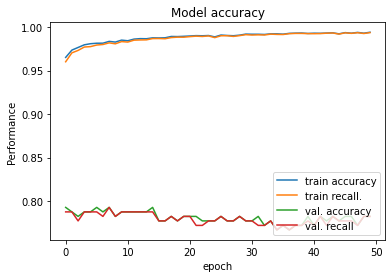

In [ ]:
# summarize history for accuracy
plt.plot(hst.history['accuracy'])
plt.plot(hst.history['recall'])
plt.plot(hst.history['val_accuracy'])
plt.plot(hst.history['val_recall'])
plt.title('Model accuracy')
plt.ylabel('Performance')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'train recall.', 'val. accuracy', 'val. recall'], loc='lower right')
plt.show()

In [ ]:
#save last model
model2.save(last_model_fpath)

In [ ]:
#last_model_fpath = '/content/drive/MyDrive/PHD/Model/last_model_smote on feature space_under70_224px.h5'
last_model = load_model(last_model_fpath, custom_objects={'balanced_acc' : balanced_acc})
y_train_pred = last_model.predict(X_train)
y_val_pred = last_model.predict(X_val)

#print('accuracy on training',accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1)))
print('accuracy on training',accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1)))
print('balanced accuracy on training',balanced_accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1)))
print('accuracy on validation',accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1)))
print('balanced accuracy on validation',balanced_accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1)))
print('F1.5-score on validation',fbeta_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1),average='macro', beta=1.5))
print('Score on val data: ',precision_recall_fscore_support(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1), average='macro'))

7/7 [==============================] - 0s 2ms/step
accuracy on training 0.9995763224791188
balanced accuracy on training 0.9996
accuracy on validation 0.7823834196891192
balanced accuracy on validation 0.6937953451890735
F1.5-score on validation 0.6106450270938172
Score on val data:  (0.6022689726585039, 0.6937953451890735, 0.596606523025737, None)


In [ ]:
#best_model_fpath = '/content/drive/MyDrive/PHD/Model/best_model_smote on feature space_under70_224px.h5'
best_model = load_model(best_model_fpath, custom_objects={'balanced_acc' : balanced_acc})
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)

print('accuracy on training',accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1)))
print('balanced accuracy on training',balanced_accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1)))
print('accuracy on validation',accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1)))
print('balanced accuracy on validation',balanced_accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1)))
print('F1.5-score on validation',fbeta_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1),average='macro', beta=1.5))
print('Score on val data: ',precision_recall_fscore_support(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1), average='macro'))

7/7 [==============================] - 0s 2ms/step
accuracy on training 0.9956421740709357
balanced accuracy on training 0.9958857142857144
accuracy on validation 0.7927461139896373
balanced accuracy on validation 0.7098126612063895
F1.5-score on validation 0.6266437620555286
Score on val data:  (0.6203460568646204, 0.7098126612063895, 0.6129663486847541, None)


In [ ]:
print(exp_name, dataset_name)

shade_of_gray_cc without ov under70_128px_raw


#Load ISIC 2018 Challange Data

In [ ]:
X_train, y_train, X_val, y_val, df_train, df_val = load_isic2018_dataset(train_under_frac = train_under_frac)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print('Counter train data: ', Counter(np.argmax(y_train, axis=1)))
print('Counter val data: ', Counter(np.argmax(y_val, axis=1)))
print('df_train df_val shape: ', df_train.shape, df_val.shape)

loading data from csv
random undersampling by  30.000000000000004 %
resize image to:  (128, 128)
y_train and y_val to categorical
(5321, 128, 128, 3)
(5321, 7)
(193, 128, 128, 3)
(193, 7)
Counter train data:  Counter({5: 2011, 4: 1113, 2: 1099, 1: 514, 0: 327, 6: 142, 3: 115})
Counter val data:  Counter({5: 123, 2: 22, 4: 21, 1: 15, 0: 8, 6: 3, 3: 1})
df_train df_val shape:  (5321,) (193,)


In [ ]:
print('df_train df_val shape: ', df_train.shape, df_val.shape)

df_train df_val shape:  (5321,) (193,)


In [ ]:
print("before preprocessing")
print(X_train[0])
print(X_val[0])

In [ ]:
X_train = preprocess_image_input(X_train, the_arch)
X_val = preprocess_image_input(X_val, the_arch)

preprocess data
preprocess data


In [ ]:
print("after preprocessing")
print(X_train[0])
print(X_val[0])

In [ ]:
path = '/content/drive/MyDrive/PHD/Datasets/isic2018/'
df1 = pd.DataFrame(X_train.reshape(X_train.shape[0],-1))
df1['y_train'] = np.argmax(y_train, axis=1).tolist()
df1['image'] = df_train.tolist()
df2 = pd.DataFrame(X_val.reshape(X_val.shape[0],-1))
df2['y_val'] = np.argmax(y_val, axis=1).tolist()
df2['image'] = df_val.tolist()
print('df1 shape: ',df1.shape)
print('df2 shape: ',df2.shape)
df1.to_pickle(path+"isic2018_train_"+dataset_name+".pkl")
df2.to_pickle(path+"isic2018_val_"+dataset_name+".pkl")
print("dataset saved:", dataset_name)

df1 shape:  (5321, 49154)
df2 shape:  (193, 49154)
dataset saved: under70_128px_raw


In [ ]:

df1.to_pickle(path+"isic2018_train_"+exp_name+"_"+dataset_name+".pkl")#REMEMBER TO DELETE _. JUST IN CASE
df2.to_pickle(path+"isic2018_val_"+exp_name+"_"+dataset_name+".pkl")#REMEMBER TO DELETE _. JUST IN CASE
print("dataset saved:", exp_name+"_"+dataset_name)

dataset saved: smote on IS far from centroid_under70_128px


In [ ]:
# ordered count of rows per unique label
labels_count = y_train.value_counts(ascending=True)

f = plt.figure(figsize=(15, 6))
s = sns.barplot(x=labels_count.index,y=labels_count.values)
s.set_xticklabels(s.get_xticklabels(), rotation = 30)

Plot 3 images per label

In [ ]:
def plot_images_per_label(df, label, cols: int, size: tuple):
    fig, axs = plt.subplots(nrows=1, ncols=cols, figsize=size)

    cntMax = cols
    cntCur = 0
    for index, row in df.iterrows():
        if(y_train == label and cntCur < cntMax):
            axs[cntCur].imshow(plt.imread(df.FilePaths[index]))
            axs[cntCur].set_title(df.Labels[index])

            cntCur += 1
        else:
            if(cntCur >= cntMax):
                break
    
    plt.tight_layout()
    plt.show()


# unique labels
labels = sorted(df1['y_train'].unique())
for label in range(7):
    plot_images_per_label(df1, label, 3, (12,9))

In [ ]:
from PIL import Image
img = Image.fromarray(X_train[0], 'RGB')
display(img)

Drop duplicate images

In [ ]:
#df_group = pd.read_csv('/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Training_LesionGroupings.csv') 
#df_train = df_train.set_index('image').join(df_group.set_index('image'))
#df_train = df_train.drop_duplicates(subset=['lesion_id'])

#DeepSMOTE Oversampling

In [ ]:
from numpy import moveaxis
from sklearn.neighbors import NearestNeighbors
import torch
import torch.nn as nn

max_el = np.inf

args = {}
args['dim_h'] = 64         # factor controlling size of hidden layers
args['n_channel'] = 3#1    # number of channels in the input data 
args['n_z'] = 600 #300     # number of dimensions in latent space. 
args['sigma'] = 1.0        # variance in n_z
args['lambda'] = 0.01      # hyper param for weight of discriminator loss
args['lr'] = 0.0002        # learning rate for Adam optimizer .000
args['epochs'] = EPOCHS       # how many epochs to run for
args['batch_size'] = 100   # batch size for SGD
args['save'] = True        # save weights at each epoch of training if True
args['train'] = True       # train networks if True, else load networks from
args['patience'] = 20

In [ ]:
class Encoder(nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']
        
        # convolutional filters, work excellent with image data
        # [(W−K+2P)/S]+1
        self.conv = nn.Sequential(
            #nn.AvgPool2d(7, stride=7),
            nn.Conv2d(self.n_channel, self.dim_h, 5, 3, 0, bias=False),# 42
            nn.BatchNorm2d(self.dim_h),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 5, 3, 1, bias=False), # 14
            nn.BatchNorm2d(self.dim_h * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 5, 3, 0, bias=False),# 4
            nn.BatchNorm2d(self.dim_h * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 1, 0, bias=False),#1
            nn.BatchNorm2d(self.dim_h * 8),
            nn.LeakyReLU(0.2, inplace=True))
        self.fc = nn.Linear(self.dim_h * 8, self.n_z)

    def forward(self, x):
        x = self.conv(x)
        
        x = x.squeeze()
        x = self.fc(x)
        return x


class Decoder(nn.Module):
    def __init__(self, args):
        super(Decoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # first layer is fully connected
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 2**3 * 3 * 3),
            nn.ReLU())

        # deconvolutional filters, essentially inverse of convolutional filters
        # H_out ​= (H_in​−1)*stride[0] − 2×padding[0] + dilation[0]×(kernel_size[0]−1) + output_padding[0] + 1
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 3,2,0), #7
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4,2,1), #14
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 2, self.dim_h, 5,3,1), #42
            nn.BatchNorm2d(self.dim_h),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h, 3, 5,3,0),# 128
            #nn.BatchNorm2d(self.dim_h),
            #nn.ReLU(True),
            #nn.ConvTranspose2d(self.dim_h, 3, 4, 2, 1),# 32
            #nn.UpsamplingBilinear2d(scale_factor=7),
            nn.Tanh())

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.dim_h * 2**3, 3, 3)
        x = self.deconv(x)
        return x

##############################################################################
"""set models, loss functions"""
# control which parameters are frozen / free for optimization
def free_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = True

def frozen_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = False

def biased_get_class(X, y, c):
    
    xbeg = X[y == c]
    ybeg = y[y == c]
    
    return xbeg, ybeg
    #return xclass, yclass

def G_SM(X, y,n_to_sample,cl):
    n_neigh = 5
    nn = NearestNeighbors(n_neighbors=n_neigh, n_jobs=1)
    nn.fit(X)
    dist, ind = nn.kneighbors(X)
    X_mean = np.mean(X, axis=0)
    # generating samples
    base_indices = np.random.choice(list(range(len(X))),n_to_sample)
    neighbor_indices = np.random.choice(list(range(1, n_neigh)),n_to_sample)

    X_base = X[base_indices]
    X_neighbor = X[ind[base_indices, neighbor_indices]]
    dist_base = np.linalg.norm(X_base-X_mean[None,:], axis=1)
    dist_neighbor = np.linalg.norm(X_neighbor-X_mean[None,:], axis=1)
    dist = dist_base > dist_neighbor
    rand_fact = np.random.uniform(low=0, high=0.5, size=(n_to_sample,1))
    #rand_fact[np.logical_not(dist)] += 0.5
    rand_fact[dist] += 0.5

    #samples = X_base + np.multiply(rand_fact, X_neighbor - X_base)
    samples = X_base + np.multiply(np.random.rand(n_to_sample,1), X_neighbor - X_base)

    #use 10 as label because 0 to 9 real classes and 1 fake/smoted = 10
    return samples, [cl]*n_to_sample

def DeepSMOTE_train(X_train, y_train, one_hot = False):
  from torch.utils.data import TensorDataset
  import os

  max_el = np.max(X_train)
  X_train = X_train / max_el
  X_train = moveaxis(X_train, 3, 1)
  if one_hot:
    y_train = np.argmax(y_train, axis=1)
  #X_train = X_train.astype('float32') / 255.
  
  batch_size = args['batch_size']
  patience = args['patience']
  encoder = Encoder(args)
  decoder = Decoder(args)

  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  print(device)
  decoder = decoder.to(device)
  encoder = encoder.to(device)

  train_on_gpu = torch.cuda.is_available()

  #decoder loss function
  criterion = nn.MSELoss()
  criterion = criterion.to(device)

  num_workers = 0

  #torch.Tensor returns float so if want long then use torch.tensor
  tensor_x = torch.from_numpy(X_train.copy())#torch.Tensor(X_train)
  tensor_y = torch.tensor(y_train,dtype=torch.long)
  mnist_bal = TensorDataset(tensor_x,tensor_y) 
  train_loader = torch.utils.data.DataLoader(mnist_bal, 
      batch_size=batch_size,shuffle=True,num_workers=num_workers)

  best_loss = np.inf

  enc_optim = torch.optim.Adam(encoder.parameters(), lr = args['lr'])
  dec_optim = torch.optim.Adam(decoder.parameters(), lr = args['lr'])

  for epoch in range(args['epochs']):
      train_loss = 0.0
      tmse_loss = 0.0
      tdiscr_loss = 0.0
      # train for one epoch -- set nets to train mode
      encoder.train()
      decoder.train()
  
      for images,labs in train_loader:
      
          # zero gradients for each batch
          encoder.zero_grad()
          decoder.zero_grad()
          images, labs = images.to(device), labs.to(device)
          labsn = labs.detach().cpu().numpy()
#            print('images shape', images.shape)
          # run images
          z_hat = encoder(images)
#            print('images shape after encoding', z_hat.shape)
      
          x_hat = decoder(z_hat) #decoder outputs tanh
#            print('images shape after decoding', x_hat.shape)
          mse = criterion(x_hat,images)
                  
          #resx = []
          #resy = []
      
          tc = np.random.choice(num_classes,1)
          #tc = 9
          xbeg = X_train[y_train == tc]
          ybeg = y_train[y_train == tc] 
          xlen = len(xbeg)
          nsamp = min(xlen, 100)
          ind = np.random.choice(list(range(len(xbeg))),nsamp,replace=False)
          xclass = xbeg[ind]
          yclass = ybeg[ind]
      
          xclen = len(xclass)
          xcminus = np.arange(1,xclen)
          
          xcplus = np.append(xcminus,0)
          xcnew = (xclass[[xcplus],:])
          xcnew = xcnew.reshape(xcnew.shape[1],xcnew.shape[2],xcnew.shape[3],xcnew.shape[4])
      
          xcnew = torch.Tensor(xcnew)
          xcnew = xcnew.to(device)
      
          #encode xclass to feature space
          xclass = torch.Tensor(xclass)
          xclass = xclass.to(device)
          xclass = encoder(xclass)
      
          xclass = xclass.detach().cpu().numpy()
      
          xc_enc = (xclass[[xcplus],:])
          xc_enc = np.squeeze(xc_enc)
      
          xc_enc = torch.Tensor(xc_enc)
          xc_enc = xc_enc.to(device)
          
          ximg = decoder(xc_enc)
          
          mse2 = criterion(ximg,xcnew)
      
          comb_loss = mse2 + mse
          comb_loss.backward()
      
          enc_optim.step()
          dec_optim.step()
      
          train_loss += comb_loss.item()*images.size(0)
          tmse_loss += mse.item()*images.size(0)
          tdiscr_loss += mse2.item()*images.size(0)

      train_loss = train_loss/len(train_loader)
      tmse_loss = tmse_loss/len(train_loader)
      tdiscr_loss = tdiscr_loss/len(train_loader)
      print('Epoch: {} \tTrain Loss: {:.6f} \tmse loss: {:.6f} \tmse2 loss: {:.6f}'.format(epoch,
              train_loss,tmse_loss,tdiscr_loss))
      
  
  
      #store the best encoder and decoder models
      #here, /crs5 is a reference to 5 way cross validation, but is not
      #necessary for illustration purposes
      if train_loss < best_loss:
          print('Saving best encoder - decoder')
          patience = args['patience']
          path_enc = '/content/drive/MyDrive/PHD/Model/best_enc_'+exp_name+'_'+dataset_name+'.pth'
          path_dec = '/content/drive/MyDrive/PHD/Model/best_dec_'+exp_name+'_'+dataset_name+'.pth'
        
          torch.save(encoder.state_dict(), path_enc)
          torch.save(decoder.state_dict(), path_dec)
  
          best_loss = train_loss
      else:
          patience = patience - 1

      if patience == 0:
          print('Out of patience. \n')
          break
  print('Saving last encoder - decoder')
  path_enc = '/content/drive/MyDrive/PHD/Model/last_enc_'+exp_name+'_'+dataset_name+'.pth'
  path_dec = '/content/drive/MyDrive/PHD/Model/last_dec_'+exp_name+'_'+dataset_name+'.pth'

  torch.save(encoder.state_dict(), path_enc)
  torch.save(decoder.state_dict(), path_dec)

def DeepSMOTE_Data(X_train, y_train, one_hot = False, use_model="best"):
  batch_size = args['batch_size']
  max_el = np.max(X_train)
  X_train = X_train / max_el
  X_train = moveaxis(X_train, 3, 1)
  if one_hot:
    y_train = np.argmax(y_train, axis=1)
  #Generate artificial images
  import torch
  np.printoptions(precision=5,suppress=True)

  #path on the computer where the models are stored
  if use_model == 'best':
    path_enc = '/content/drive/MyDrive/PHD/Model/best_enc_'+exp_name+'_'+dataset_name+'.pth'
    path_dec = '/content/drive/MyDrive/PHD/Model/best_dec_'+exp_name+'_'+dataset_name+'.pth'
  else:
    path_enc = '/content/drive/MyDrive/PHD/Model/last_enc_'+exp_name+'_'+dataset_name+'.pth'
    path_dec = '/content/drive/MyDrive/PHD/Model/last_dec_'+exp_name+'_'+dataset_name+'.pth'
  
  train_on_gpu = torch.cuda.is_available()
  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  print("Load model: ", path_enc)
  encoder = Encoder(args)
  encoder.load_state_dict(torch.load(path_enc), strict=False)
  encoder = encoder.to(device)

  print("Load model: ", path_dec)
  decoder = Decoder(args)
  decoder.load_state_dict(torch.load(path_dec), strict=False)
  decoder = decoder.to(device)

  encoder.eval()
  decoder.eval()

  resx = []
  resy = []
  
  counter = Counter(y_train)
  counter = sorted(counter.items())
  counter = [value for _, value in counter]

  for i in range(num_classes):
      torch.cuda.empty_cache()

      xclass, yclass = biased_get_class(X_train, y_train, i)
      #encode xclass to feature space
      xclass = torch.Tensor(xclass)
      xclass = xclass.to(device)
      xclass = encoder(xclass)
          
      xclass = xclass.detach().cpu().numpy()
      n = np.max(counter) - counter[i]
      if n <= 0:
        continue
      xsamp, ysamp = G_SM(xclass,yclass,n,i)
      ysamp = np.array(ysamp)
  
      """to generate samples for resnet"""   
      xsamp = torch.Tensor(xsamp)
      xsamp = xsamp.to(device)
      ximg = decoder(xsamp)

      ximn = ximg.detach().cpu().numpy()
      resx.append(ximn)
      resy.append(ysamp)
  
  resx1 = np.vstack(resx)
  resy1 = np.hstack(resy)
  resx1 = resx1.reshape(resx1.shape[0],-1)
  X_train = X_train.reshape(X_train.shape[0],-1)
  X_train = np.vstack((resx1,X_train))
  y_train = np.hstack((resy1,y_train))
  y_train = to_categorical(y_train)
  X_train = X_train.reshape(-1, 3, IMAGE_W, IMAGE_H)
  X_train = moveaxis(X_train, 1, 3)
  X_train = X_train * max_el
  return X_train, y_train

In [ ]:
#encoder
W=4
K=4
S=2
P=0
Wout = ((W-K+2*P)/S)+1
print(Wout)

1.0


In [ ]:
#Decoder 8
H_in= 64
kernel_size = 4
stride = 2
padding = 1
dilation = 1

output_padding=0
H_out = (H_in - 1)*stride - 2*padding + dilation*(kernel_size-1) + output_padding + 1
print (H_out)

128


In [ ]:
DeepSMOTE_train(X_train, y_train, True)

cuda
Epoch: 0 	Train Loss: 20.196150 	mse loss: 9.990886 	mse2 loss: 10.205264
Saving best encoder - decoder
Epoch: 1 	Train Loss: 6.665930 	mse loss: 3.215490 	mse2 loss: 3.450441
Saving best encoder - decoder
Epoch: 2 	Train Loss: 4.093358 	mse loss: 1.888233 	mse2 loss: 2.205125
Saving best encoder - decoder
Epoch: 3 	Train Loss: 3.371739 	mse loss: 1.503221 	mse2 loss: 1.868517
Saving best encoder - decoder
Epoch: 4 	Train Loss: 2.962867 	mse loss: 1.331350 	mse2 loss: 1.631517
Saving best encoder - decoder
Epoch: 5 	Train Loss: 2.721816 	mse loss: 1.240513 	mse2 loss: 1.481303
Saving best encoder - decoder
Epoch: 6 	Train Loss: 2.606059 	mse loss: 1.151597 	mse2 loss: 1.454462
Saving best encoder - decoder
Epoch: 7 	Train Loss: 2.371876 	mse loss: 1.009849 	mse2 loss: 1.362027
Saving best encoder - decoder
Epoch: 8 	Train Loss: 2.312727 	mse loss: 1.037194 	mse2 loss: 1.275533
Saving best encoder - decoder
Epoch: 9 	Train Loss: 2.291991 	mse loss: 0.963235 	mse2 loss: 1.328756
Sav

In [ ]:
X_train, y_train = DeepSMOTE_Data(X_train, y_train, one_hot = True, use_model="best")
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print('Counter train data: ', Counter(np.argmax(y_train, axis=1)))
print('Counter val data: ', Counter(np.argmax(y_val, axis=1)))

Load model:  /content/drive/MyDrive/PHD/Model/best_enc_shade_of_gray_cc with deepsmote_under70_128px_raw.pth
Load model:  /content/drive/MyDrive/PHD/Model/best_dec_shade_of_gray_cc with deepsmote_under70_128px_raw.pth
(14077, 128, 128, 3)
(14077, 7)
(193, 128, 128, 3)
(193, 7)
Counter train data:  Counter({0: 2011, 1: 2011, 2: 2011, 3: 2011, 4: 2011, 6: 2011, 5: 2011})
Counter val data:  Counter({5: 123, 2: 22, 4: 21, 1: 15, 0: 8, 6: 3, 3: 1})


In [ ]:
path_enc = '/content/drive/MyDrive/PHD/Model/best_enc_'+exp_name+'_'+dataset_name+'.pth'
path_dec = '/content/drive/MyDrive/PHD/Model/best_dec_'+exp_name+'_'+dataset_name+'.pth'
encoder = Encoder(args)
encoder.load_state_dict(torch.load(path_enc), strict=False)

decoder = Decoder(args)
decoder.load_state_dict(torch.load(path_dec), strict=False)

<All keys matched successfully>

#Split dataset to train and val

In [ ]:
# stratified train and rem (20%) datasets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=1)

print('Train Data: ', X_train.shape)
print('Remaining Data: ', X_val.shape)

In [ ]:
#Data Augmentation
dataaugment = ImageDataGenerator(
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range = 10) 

dataaugment.fit(X_train)

#Fine Tune

In [ ]:
limit = 171
for layer in model.layers[:limit]:
   layer.trainable = False
for layer in model.layers[limit:]:
   layer.trainable = True

optimizer_SGD = SGD(learning_rate=0.0001, momentum=0.9)
model.compile(optimizer = optimizer_SGD , loss = "categorical_crossentropy", metrics=['accuracy', balanced_acc])
hst2 = model.fit(train_data_batches,
                    epochs = EPOCHS, validation_data = valid_data_batches,
                    callbacks=[learning_rate_reduction,early_stopping_monitor, mc])


In [ ]:
# summarize history for accuracy
plt.plot(hst2.history['balanced_acc'])
plt.plot(hst2.history['val_balanced_acc'])
plt.title('model balance_acc after tunning')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()